In [759]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import stats
%matplotlib inline
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
import warnings

In [760]:
warnings.filterwarnings('ignore')
data = pd.read_csv('train.csv')
pd.set_option('display.max_columns', None)
data.head()

,ID,worked_in_the_past,age_group,disability,is_dev,education,sex,mental_issues,years_of_experience,A,B,C,D,country,prev_salary,stack_experience,label
0,65168,T,young,No,developer,NaN,Male,No,13.0,-1.093080,1.0,aa,180.984266,NaN,67104.0,Bash/Shell;Java;JavaScript;PowerShell;Python;T...,1
1,38314,T,young,No,non-developer,other,Male,Yes,7.0,5.444533,7.0,rhz,180.677533,United States of America,101000.0,Bash/Shell;JavaScript;PowerShell;Python;Docker...,0
2,5209,T,old,No,developer,other,Male,Yes,25.0,1.727255,15.0,aa,177.746162,United States of America,70000.0,Bash/Shell;HTML/CSS;Java;JavaScript;PHP;SQL;Gi...,0
3,54165,T,young,NaN,developer,other,Male,No,10.0,17.804302,7.0,aa,176.952584,Spain,40956.0,C#;Dart;Delphi;Kotlin;SQL;VBA;Docker;Unity 3D;...,0
4,42213,T,young,No,developer,BA/BSc,Male,No,12.0,-8.679091,4.0,hr,179.393259,Canada,101509.0,Assembly;Bash/Shell;C++;PowerShell;Python;Rust,0


# Parts 1 & 2 : Data exploration and Preprocessing

Dropping the ID Feature

Reason for Dropping the ID Feature:

The ID feature is typically a unique identifier for each individual or record in the dataset. Since ID numbers are random and do not provide any meaningful information about the individuals, they do not contribute to the predictive power our model. Including the ID feature can introduce noise and potentially lead to overfitting, as the model might learn to associate specific ID numbers with outcomes inappropriately.

In [761]:
def drop_column(X, lst):
    X = X.drop(columns=lst)
    return X

In [762]:
# Drop the ID feature
data = drop_column(data, ['ID'])

# Display the first few rows of the DataFrame to show the ID feature has been dropped
data.head()


,worked_in_the_past,age_group,disability,is_dev,education,sex,mental_issues,years_of_experience,A,B,C,D,country,prev_salary,stack_experience,label
0,T,young,No,developer,NaN,Male,No,13.0,-1.093080,1.0,aa,180.984266,NaN,67104.0,Bash/Shell;Java;JavaScript;PowerShell;Python;T...,1
1,T,young,No,non-developer,other,Male,Yes,7.0,5.444533,7.0,rhz,180.677533,United States of America,101000.0,Bash/Shell;JavaScript;PowerShell;Python;Docker...,0
2,T,old,No,developer,other,Male,Yes,25.0,1.727255,15.0,aa,177.746162,United States of America,70000.0,Bash/Shell;HTML/CSS;Java;JavaScript;PHP;SQL;Gi...,0
3,T,young,NaN,developer,other,Male,No,10.0,17.804302,7.0,aa,176.952584,Spain,40956.0,C#;Dart;Delphi;Kotlin;SQL;VBA;Docker;Unity 3D;...,0
4,T,young,No,developer,BA/BSc,Male,No,12.0,-8.679091,4.0,hr,179.393259,Canada,101509.0,Assembly;Bash/Shell;C++;PowerShell;Python;Rust,0


In [763]:
# Define the condition for outliers
outlier_condition = (data['age_group'] == 'young') & (data['years_of_experience'] > 18)

# Drop the outliers from the dataset
data = data[~outlier_condition]

# Display the cleaned dataset
print(data.shape)

(54087, 16)


Assuming that people generally don't start working before the age of 17 and considering that the maximum age in the "young" age group is 35, we have decided that any samples belonging to the "young" age group with more than 18 years of experience are outliers. Therefore, we have removed these outlier samples from the dataset.

In [764]:
all_cols = data.columns

array([[<Axes: title={'center': 'B'}>, <Axes: title={'center': 'A'}>],
       [<Axes: title={'center': 'years_of_experience'}>,
        <Axes: title={'center': 'D'}>],
       [<Axes: title={'center': 'prev_salary'}>, <Axes: >]], dtype=object)

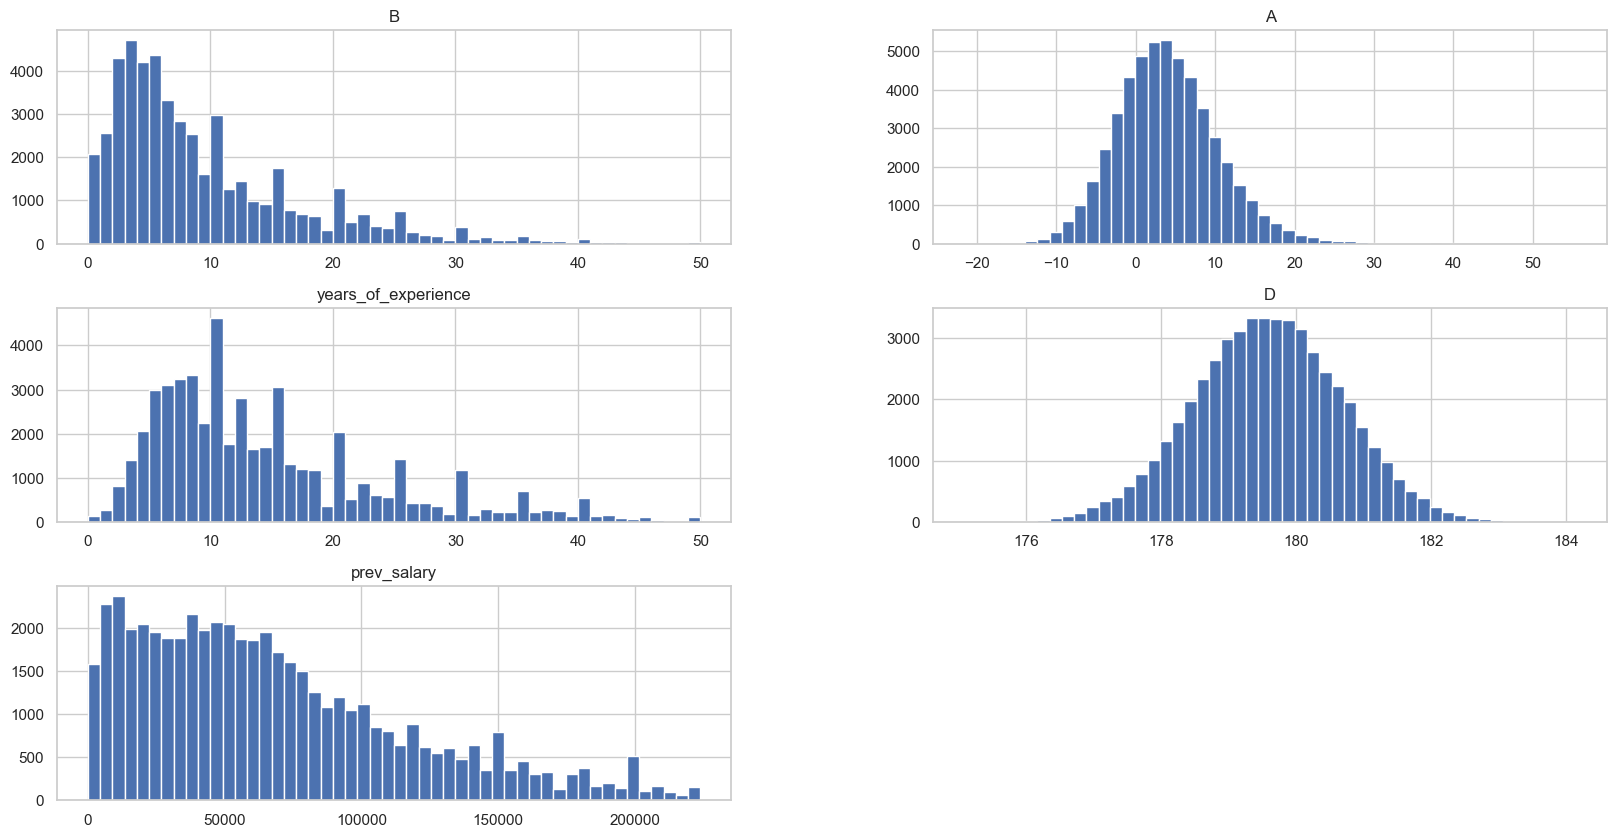

In [765]:
numeric = data.select_dtypes(include=np.number).columns
cat_cols= list(set(all_cols) - set(numeric))

data.loc[:,list(set(numeric)-set(['label']))].hist(figsize=(20,10), bins=50)


B:
The distribution is right-skewed.
Most data points are clustered around the lower values (0-10), with frequencies decreasing as the values increase.
There are very few data points with values above 40.

A:
The distribution appears to be approximately normal, with a peak (mean value) around 4.

prev_salary:
The distribution is right-skewed.
Most data points fall within the 0-50,000 range, with frequencies decreasing as the salary increases.
There might be some outliers with salaries exceeding 200,000.

years_of_experience:
The distribution is right-skewed.
Most data points are concentrated within the 0-10 years range, with frequencies gradually decreasing for higher years of experience.
A few individuals have experience exceeding 40 years.

D:
The distribution is approximately normal with a peak (mean value) around 179.5. 


In [766]:
def fill_nulls_with_mean(X, columns=['A', 'D']):
    precomputed_means = {}
    for col in columns:
        col_mean = X[col].mean()
        precomputed_means[col] = col_mean
        X[col].fillna(round(col_mean, 3), inplace=True)
    return X, precomputed_means

In [767]:
data, precomputed_means = fill_nulls_with_mean(data, ['A', 'D'])

In [768]:
precomputed_means

{'A': 3.99877481059379, 'D': 179.5779818878896}

In [769]:
def apply_fill_nulls_with_mean(X, precomputed_means, columns=['A', 'D']):
    for col in columns:
        col_mean = precomputed_means[col]
        X[col] = X[col].fillna(col_mean)
    return X



For a normal distribution, the mean is a good measure of central tendency. If the data has outliers, the median can be used as it is more robust to extreme values.

In [770]:
def fill_nulls_with_median(X, columns=['B','prev_salary', 'years_of_experience']):
    precomputed_medians = {}
    for col in columns:
        col_median = X[col].median()
        precomputed_medians[col] = col_median
        X[col].fillna(round(col_median, 3), inplace=True)
    return X, precomputed_medians

In [771]:
data, precomputed_medians = fill_nulls_with_median(data, ['B','prev_salary', 'years_of_experience'] )

In [772]:
precomputed_medians

{'B': 6.0, 'prev_salary': 57072.0, 'years_of_experience': 11.0}

In [773]:
def apply_fill_nulls_with_median(X, precomputed_medians, columns=['B','prev_salary', 'years_of_experience']):
    for col in columns:
        col_median = precomputed_medians[col]
        X[col] = X[col].fillna(col_median)
    return X


Since the distribution is right-skewed, the median would be a better measure of central tendency than the mean, as it is less affected by extreme values

The prev_salary data is right-skewed, so the median is preferred (over the mean) for filling the nulls as it is not influenced by the high salary outliers.

Similar to previous salaries, the years of experience is right-skewed, making the median a more reliable central measure for filling missing values.

ploting the histograms again after nulls were filled

array([[<Axes: title={'center': 'B'}>, <Axes: title={'center': 'A'}>],
       [<Axes: title={'center': 'years_of_experience'}>,
        <Axes: title={'center': 'D'}>],
       [<Axes: title={'center': 'prev_salary'}>, <Axes: >]], dtype=object)

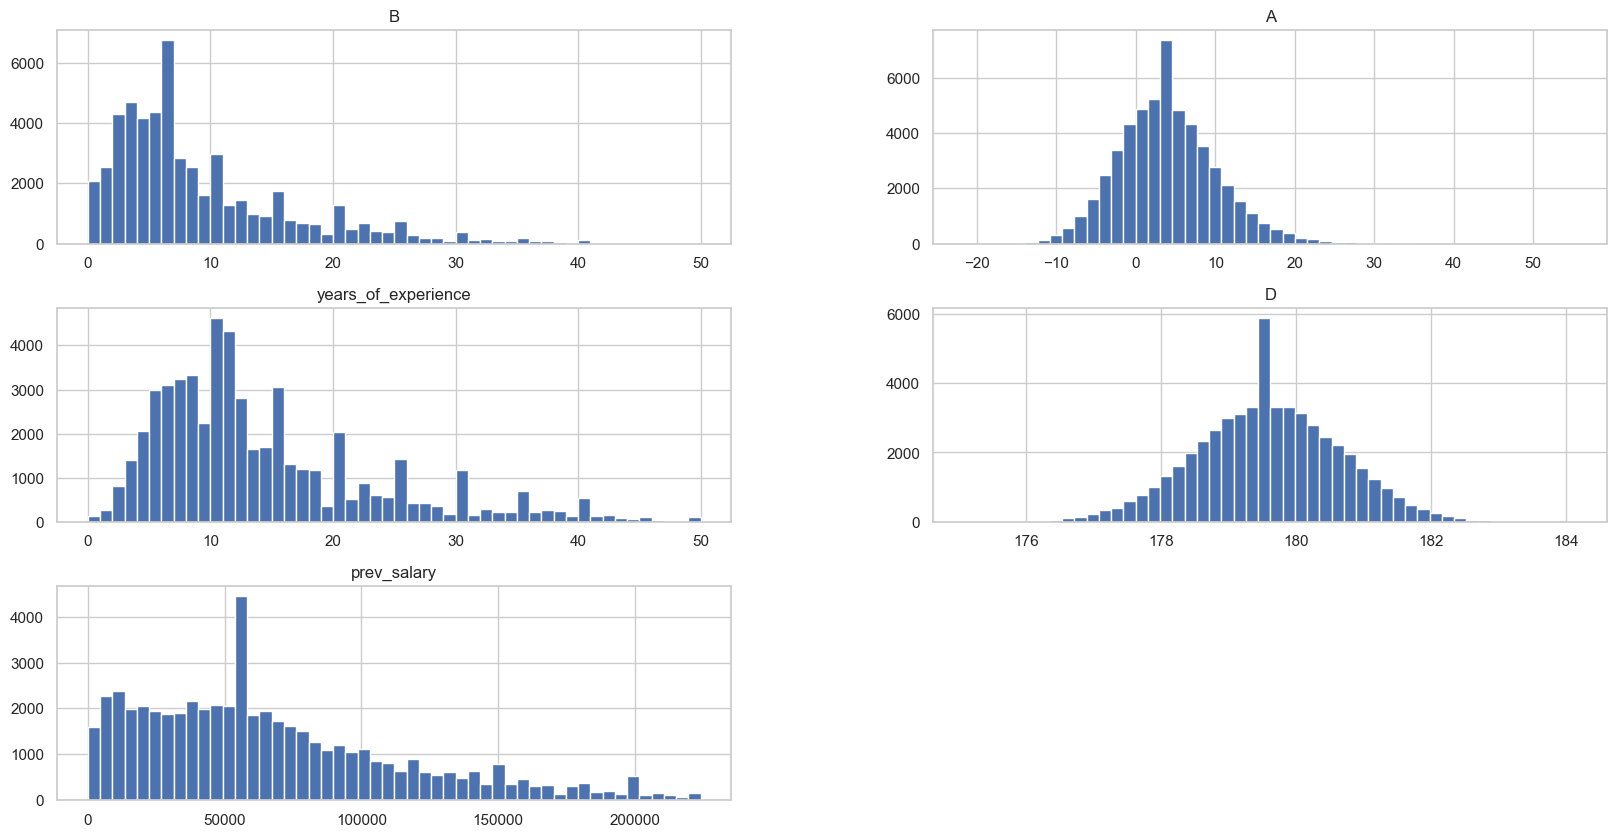

In [774]:
data.loc[:,list(set(numeric)-set(['label']))].hist(figsize=(20,10), bins=50)

In [775]:
missing_values_count = data.isnull().sum()
print(missing_values_count)

worked_in_the_past      1722
age_group               2540
disability              3599
is_dev                  2038
education               2947
sex                     3162
mental_issues           2356
years_of_experience        0
A                          0
B                          0
C                       2930
D                          0
country                 1962
prev_salary                0
stack_experience       13730
label                      0
dtype: int64


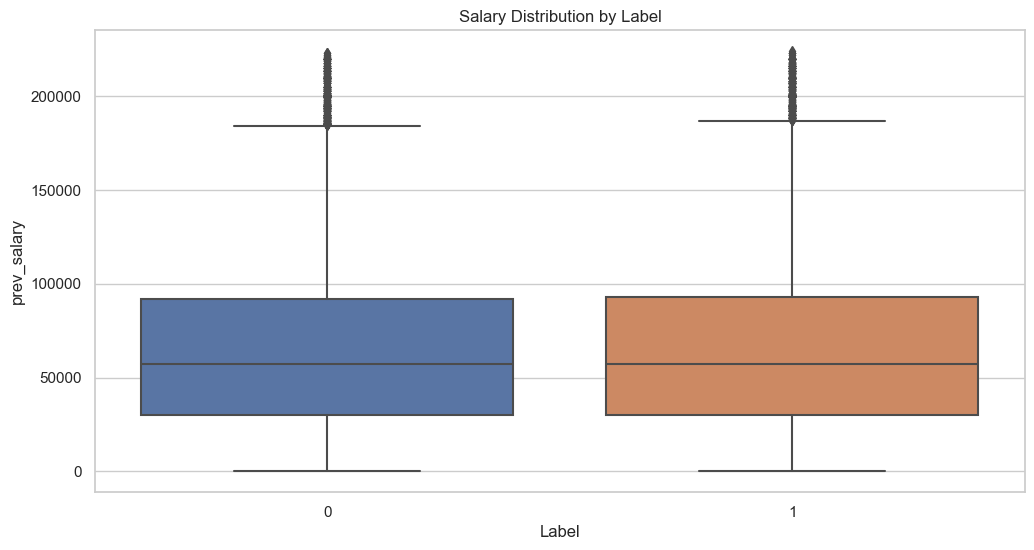

In [776]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='prev_salary', data=data)
plt.title('Salary Distribution by Label')
plt.xlabel('Label')
plt.ylabel('prev_salary')
plt.show()

The box plot above visualizes the distribution of previous salaries (prev_salary) across two different labels (Label 0 and Label 1) after nulls were filled.
Each box represents the interquartile range (IQR), which contains the middle 50% of the data (the line inside the boxes represent the median).
Data points beyond the whiskers might be outliers.

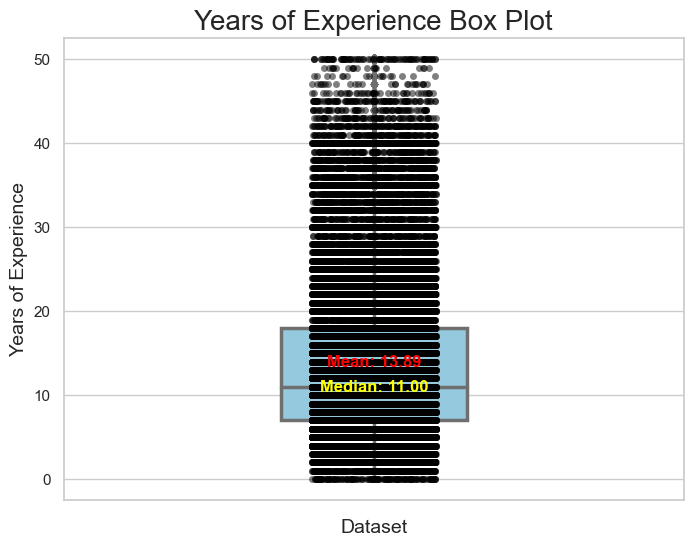

In [777]:
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

# Create the box plot with a single color
box_plot = sns.boxplot(y='years_of_experience', data=data, width=0.3, color="skyblue", linewidth=2.5)

# Customize the plot
box_plot.set_title('Years of Experience Box Plot', fontsize=20)
box_plot.set_xlabel('Dataset', fontsize=14)
box_plot.set_ylabel('Years of Experience', fontsize=14)

# Add a strip plot to show individual data points
sns.stripplot(y='years_of_experience', data=data, color='black', alpha=0.5, jitter=True)

# Calculate mean and median
mean = data['years_of_experience'].mean()
median = data['years_of_experience'].median()

# Add annotations for mean and median
plt.text(0, mean, f'Mean: {mean:.2f}', color='red', ha='center', va='center', fontsize=12, weight='bold')
plt.text(0, median, f'Median: {median:.2f}', color='yellow', ha='center', va='center', fontsize=12, weight='bold')

plt.show()


It seems there are numerous outliers above the upper whisker, extending up to 50 years of experience.

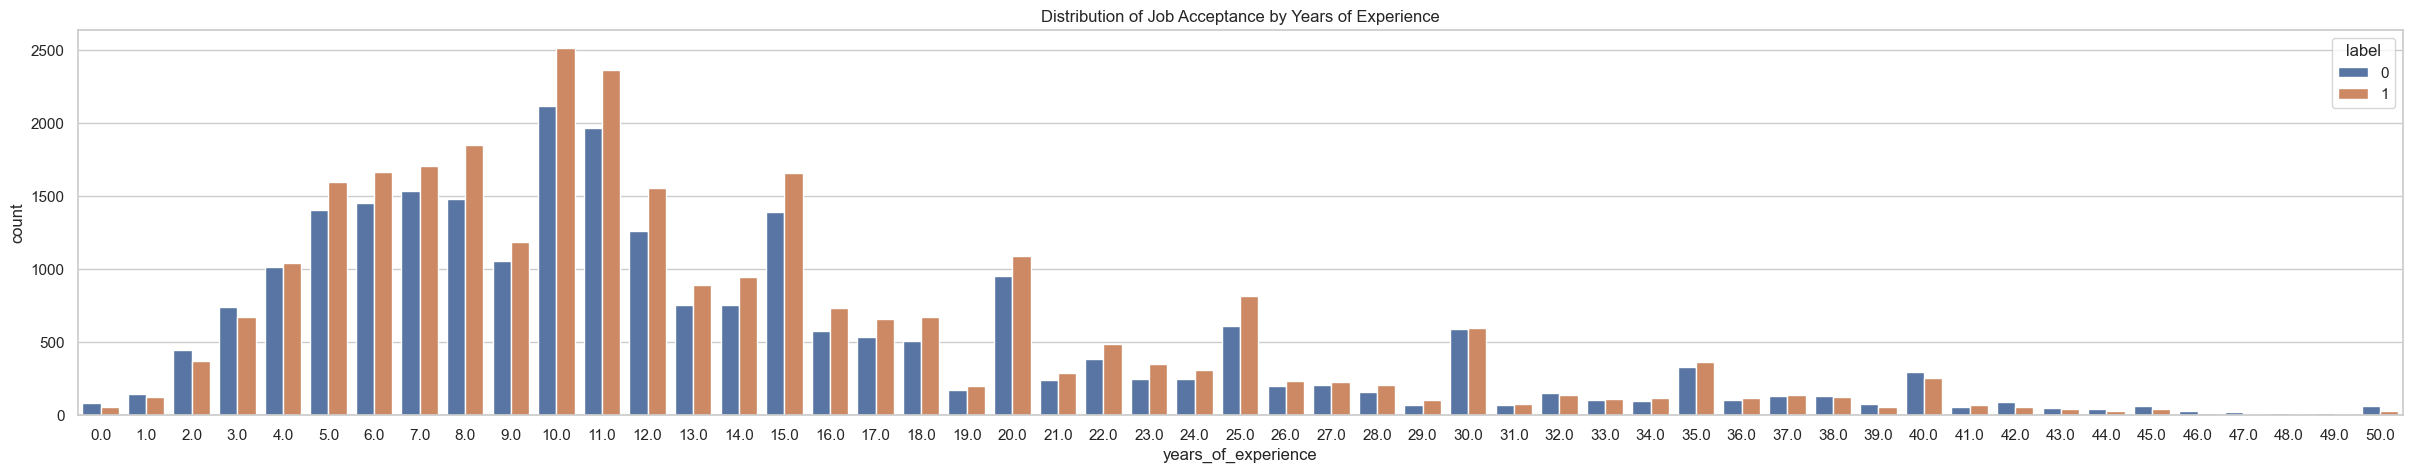

In [778]:
plt.figure(figsize=(30,5))

ax = sns.countplot(x="years_of_experience", hue="label",data=data)
plt.title("Distribution of Job Acceptance by Years of Experience")
plt.show()


Following the previous box plot, we can see in the graph above that there is a gap between 46 years of expirience to 50 (leaving 47-49 empty).
It strengthens our opinion that there are anomalis in the dataset.

In [779]:
data.head()
data.shape

(54087, 16)

finding and dropping out-liers using zscores (for the features 'A' and 'D' that seems normally distributed features).

In [780]:
#  Identify numeric columns excluding 'label' and other non-numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
columns_for_zscore = ['A', 'D']
print("Numeric columns considered for z-score calculation:", columns_for_zscore)

#  Handle NaN values by imputing them with the mean of each column
data_for_zscore_clean = data[columns_for_zscore]

#  Calculate z-scores for the numeric columns
z_scores = np.abs(stats.zscore(data_for_zscore_clean))

#  Filter out rows where any z-score is greater than or equal to 3
df_filtered = data[(z_scores < 3).all(axis=1)]

# Print shape of the original and filtered DataFrame
print("Shape of original DataFrame:", data.shape)
print("Shape of filtered DataFrame:", df_filtered.shape)
data = df_filtered

Numeric columns considered for z-score calculation: ['A', 'D']
Shape of original DataFrame: (54087, 16)
Shape of filtered DataFrame: (53559, 16)


using IQR to find outliers on numeric features that doesn't distribute normally

In [781]:
# Function to find and drop outliers using an asymmetric IQR method
def find_drop_outliers_iqr(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    print(f"{feature} - Q1: {Q1}, Q3: {Q3}")
    IQR = Q3 - Q1
    print(f"{feature} - IQR: {IQR}")
    lower_bound = Q1 - 2.5 * IQR
    upper_bound = Q3 + 2 * IQR
    suspected_outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
    data = data.drop(suspected_outliers.index)
    # after dropping the suspected outliers the auc dropped a bit. so we decided to not remove it.
    return data, suspected_outliers, lower_bound, upper_bound

# list of features to check
features = ["years_of_experience", "B" ,"prev_salary"]

# dictionary to store outliers information
suspected_outliers_dict = {}

# find outliers for each feature
for feature in features:
    data, suspected_outliers, lower_bound, upper_bound = find_drop_outliers_iqr(data, feature)
    suspected_outliers_dict[feature] = {
        "suspected_outliers": suspected_outliers,
        "lower_bound": lower_bound,
        "upper_bound": upper_bound
    }
print(data.shape)



years_of_experience - Q1: 7.0, Q3: 18.0
years_of_experience - IQR: 11.0
B - Q1: 3.0, Q3: 11.0
B - IQR: 8.0
prev_salary - Q1: 28968.0, Q3: 90000.0
prev_salary - IQR: 61032.0
(51314, 16)


We used a larger multiplier for the lower bound and a smaller multiplier for the upper bound. This is because a right-skewed distribution typically (and acoording to the histograms we have ploted above, it seems that this is our case) has more extreme values on the higher end, so a tighter bound is needed to identify those outliers accuratel

## Handling with categorial features

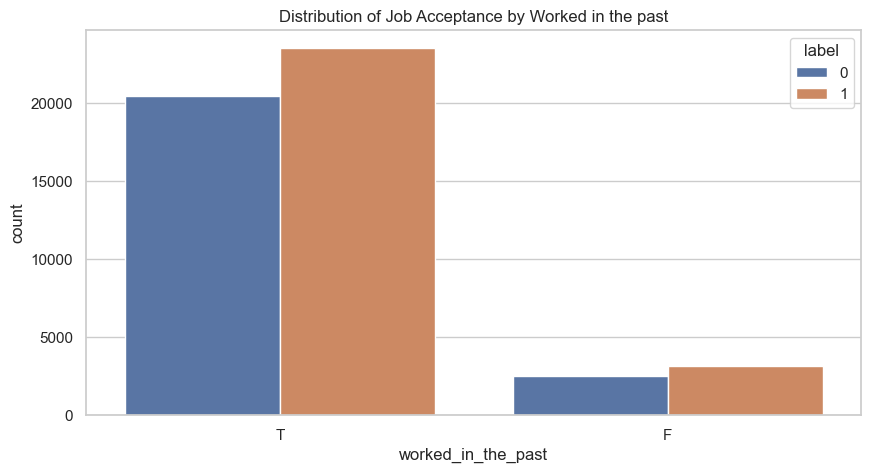

In [782]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x="worked_in_the_past", hue="label",data=data)
# data['worked_in_the_past'] = data['worked_in_the_past'].replace({"T":1,"F":0})
# worked_in_the_past_mean = data['worked_in_the_past'].mean()
# data['worked_in_the_past'].fillna(round(worked_in_the_past_mean,3), inplace=True)
plt.title("Distribution of Job Acceptance by Worked in the past")
plt.show()

In [783]:
# Function to process 'worked_in_the_past' column
def process_worked_in_the_past(X):
    X['worked_in_the_past'] = X['worked_in_the_past'].replace({"T": 1, "F": 0})
    worked_in_the_past_mean = X['worked_in_the_past'].mean()
    X['worked_in_the_past'].fillna(round(worked_in_the_past_mean, 3), inplace=True)
    return X, worked_in_the_past_mean

In [784]:
def apply_worked_in_the_past(X, mean):
    X['worked_in_the_past'] = X['worked_in_the_past'].replace({"T": 1, "F": 0})
    X['worked_in_the_past'].fillna(round(mean, 3), inplace=True)
    return X


In [ ]:
data, worked_in_the_past_mean = process_worked_in_the_past(data)
data.head(5)


Handling categorial features:
We assigned a value of 1 to all individuals who had worked in the past.
We assigned a value of 0 to all individuals who had never worked.
This transformation is based on the logical assumption that individuals who have worked in the past are more likely to be accepted for a job. We validated this assumption by analyzing the relevant histogram, which showed that those who had worked in the past had better chances of being accepted.

Handling missing values:
We filled the nulls with the mean value of the transformed feature. This approach ensures a neutral impact on the dataset, as the mean value represents a balanced point between the two categories.

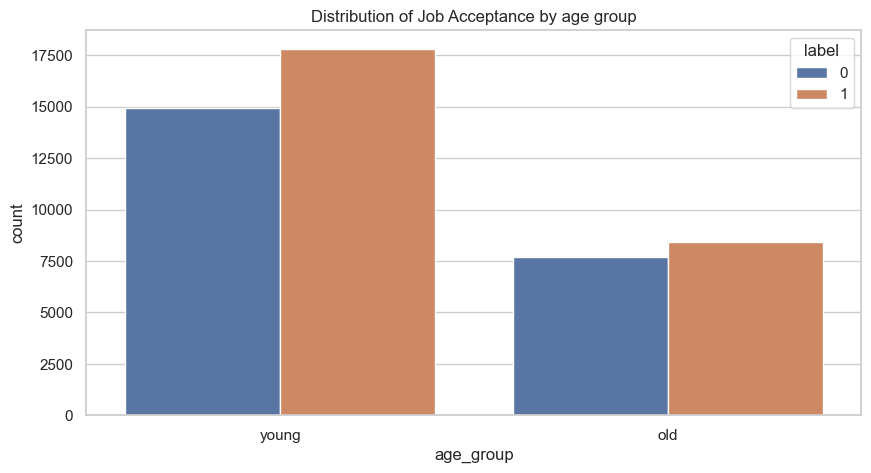

In [786]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x="age_group", hue="label",data=data)
# data['age_group'] = data['age_group'].replace({"young":0,"old":1})
# age_group_mean = data['age_group'].mean()
# data['age_group'].fillna(round(age_group_mean,3), inplace=True)
plt.title("Distribution of Job Acceptance by age group")
plt.show()

In [787]:
def process_age_group(X):
    X['age_group'] = X['age_group'].replace({"young": 0, "old": 1})
    age_group_mean = X['age_group'].mean()
    X['age_group'].fillna(round(age_group_mean, 3), inplace=True)
    return X, age_group_mean



In [788]:
data, age_group_mean = process_age_group(data)

In [789]:
def apply_process_age_group(X, age_group_mean):
    X['age_group'] = X['age_group'].replace({"young": 0, "old": 1})
    X['age_group'].fillna(round(age_group_mean, 3), inplace=True)
    return X

Handling categorial features:
in these features the data was divided to 2 categorys - old, yound (not including null for now) we used target encoding to replace the categorial data with correlation to the label. the new values are the means value of the label of each category, this way we know the impact of this feature on the label.

Handling missing values-
some of the data regarding age group was missing / null.
after replacing it's categorys we used to fill the nulls with the mean value. this way it won't "pull" to a specific directio and will be neutral.

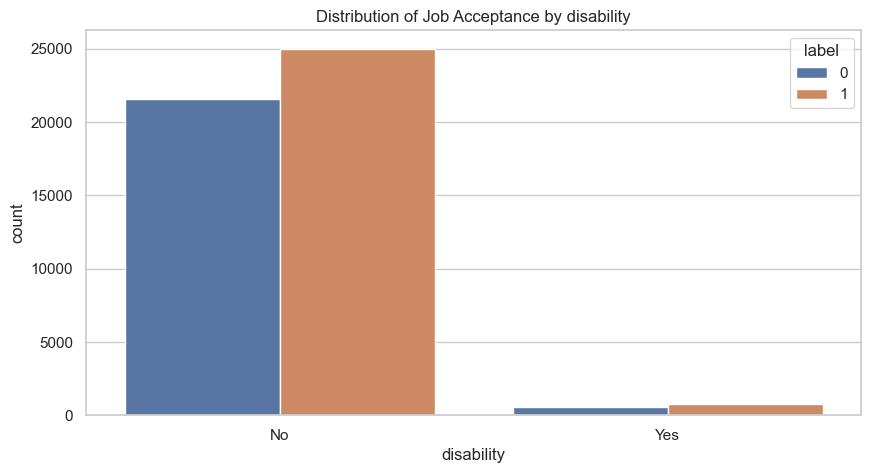

In [790]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x="disability", hue="label",data=data)
# data['disability'] = data['disability'].replace({"Yes":0,"No":1})
# disability_mean = data['disability'].mean()
# data['disability'].fillna(round(disability_mean,3), inplace=True)
plt.title("Distribution of Job Acceptance by disability")
plt.show()

In [791]:
def process_disability(X):
    X['disability'] = X['disability'].replace({"Yes": 0, "No": 1})
    disability_mean = X['disability'].mean()
    X['disability'].fillna(round(disability_mean, 3), inplace=True)
    return X, disability_mean
data, disability_mean = process_disability(data)

In [792]:
def apply_process_disability(X, disability_mean):
    X['disability'] = X['disability'].replace({"Yes": 0, "No": 1})
    X['disability'].fillna(round(disability_mean, 3), inplace=True)
    return X

Handling Categorical Features and Missing Values
Handling Categorical Features:
In this feature, we identified that having a disability is not very common, as confirmed by analyzing the histogram. We decided to encode this feature with 1 for 'has disability' and 0 for 'no disability.' This encoding ensures that the presence of a disability, which is unique and potentially impactful, is effectively captured in the model.

Handling Missing Values:
We filled the missing values in this feature with 0. This decision is based on the rationale that it is less likely for an individual to have a disability. Imputing the mean value for the missing entries would disproportionately affect a larger number of candidates, potentially skewing the model. By assigning 0, we maintain the integrity of the dataset and reflect the more probable scenario

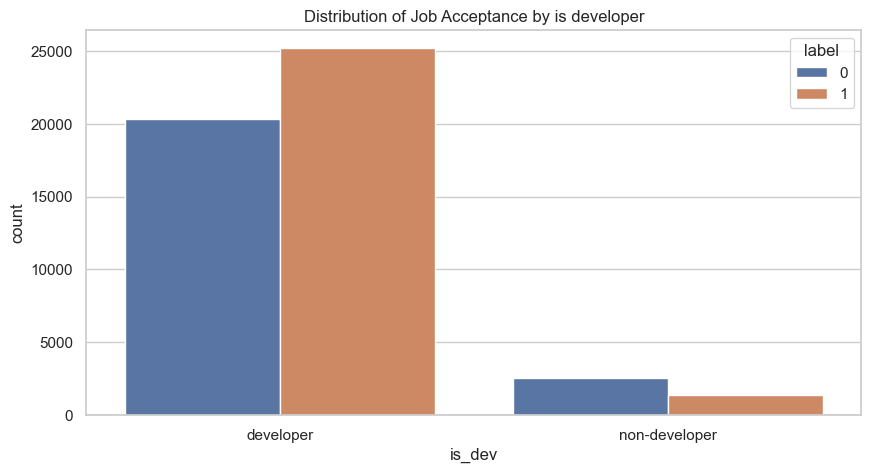

In [793]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x="is_dev", hue="label",data=data)
# data['is_dev'] = data['is_dev'].replace({"developer":1,"non-developer":-1})
# is_dev_mean = data['is_dev'].mean()
# data['is_dev'].fillna(round(is_dev_mean,3), inplace=True)
plt.title("Distribution of Job Acceptance by is developer")
plt.show()




In [794]:
def process_is_dev(X):
    X['is_dev'] = X['is_dev'].replace({"developer": 1, "non-developer": -1})
    is_dev_mean = X['is_dev'].mean()
    X['is_dev'].fillna(round(is_dev_mean, 3), inplace=True)
    return X, is_dev_mean

In [795]:
data, is_dev_mean = process_is_dev(data)

In [796]:
def apply_process_is_dev(X, is_dev_mean):
    X['is_dev'] = X['is_dev'].replace({"developer": 1, "non-developer": -1})
    X['is_dev'].fillna(round(is_dev_mean, 3), inplace=True)
    return X

Handling Categorical Features:
We transformed the categorical feature indicating whether an individual is a developer as follows:

Developers: Assigned a value of 1 to all developers. This positive value emphasizes their likely contribution to the model, based on the observation that developers have higher chances of being accepted (as you can see in the plot above).
Non-developers: Assigned a value of -1 to all non developers (excluding null values). This negative value reflects the observation that non-developers have lower chances of being accepted.
This transformation helps the model better differentiate between developers and non-developers, leveraging the positive association with acceptance rates for developers.

Handling Missing Values:

All null values in this feature were filled with the mean value. This approach ensures that the missing entries have a neutral impact on the dataset and the model.

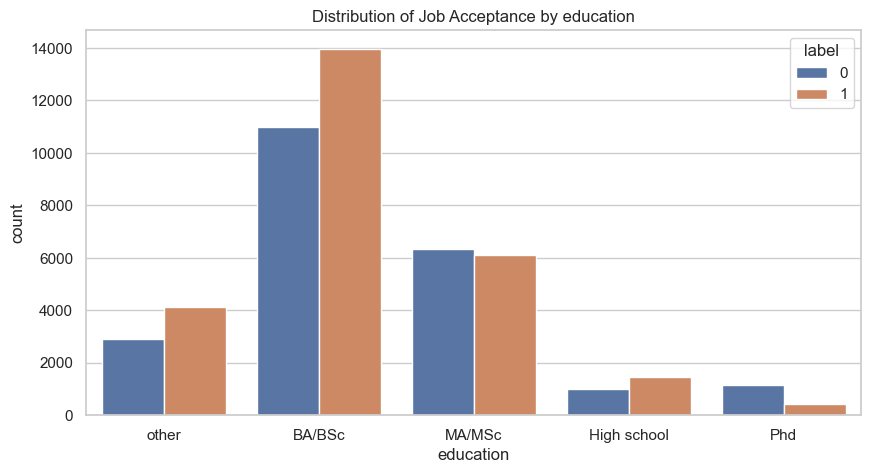

In [797]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x="education", hue="label",data=data)
plt.title("Distribution of Job Acceptance by education")
plt.show()


Handling Categorical Features:

In this section, we addressed several categories related to education using target encoding. Target encoding was used to replace the categories with their correlation values relative to the label. The steps involved were as follows:

Target Encoding:
For each category in the educational feature, we calculated the mean value of the label.
These mean values represent the correlation between each category and the label.
Each category was then replaced with its corresponding mean value.
This approach helps the model by providing numerical values that directly relate to the likelihood of the label, thereby improving the model's ability to discern patterns based on educational categories.

Handling Missing Values:

After applying target encoding, we handled the missing values in the feature by calculating the mean value of the entire feature and replacing the nulls with this mean value. This ensures that the missing entries have a neutral impact on the dataset.

the implemention is later on in the note book under the "target encoding" title

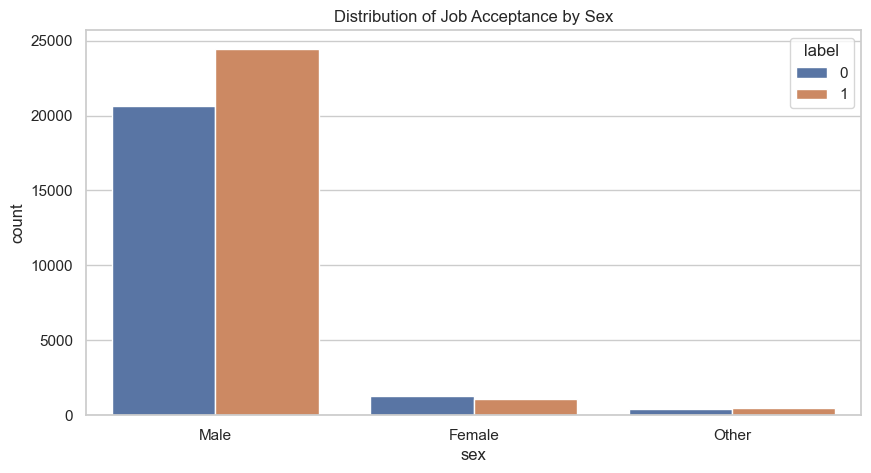

In [798]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x="sex", hue="label",data=data)
# data['sex'] = data['sex'].replace({"Male":1, "Female":0, "Other":0.5})
# sex_mean = data['sex'].mean()
# data['sex'].fillna(round(sex_mean,3), inplace=True)
plt.title("Distribution of Job Acceptance by Sex")
plt.show()

In [799]:
def process_sex(X):
    X['sex'] = X['sex'].replace({"Male": 1, "Female": 0, "Other": 0.5})
    sex_mean = X['sex'].mean()
    X['sex'].fillna(round(sex_mean, 3), inplace=True)
    return X, sex_mean
data, sex_mean = process_sex(data)

In [800]:
data, sex_mean = process_sex(data)

In [801]:
def apply_process_sex(X, sex_mean):
    X['sex'] = X['sex'].replace({"Male": 1, "Female": 0, "Other": 0.5})
    X['sex'].fillna(round(sex_mean, 3), inplace=True)
    return X


Handling Categorical Features:
we gave male 1 because the higher probabilty to get accepted, 0 for famele. we gave 0.5 to "Other"
Handeling missing values:
we calculated the mean value (that is closer to 1 because of the most of the data is regarding males) and replaced the nulls.

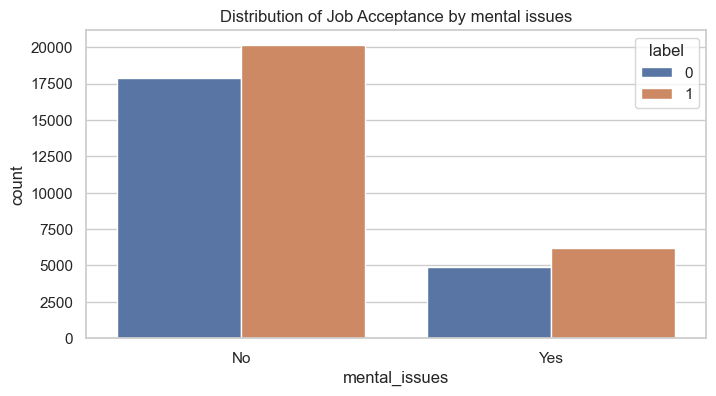

In [802]:
plt.figure(figsize=(8,4))
ax = sns.countplot(x="mental_issues", hue="label",data=data)
# data['mental_issues'] = data['mental_issues'].replace({"Yes":1, "No":0})
# mental_issues_mean = data['mental_issues'].mean()
# data['mental_issues'].fillna(round(mental_issues_mean,3), inplace=True)
plt.title("Distribution of Job Acceptance by mental issues")
plt.show()


In [803]:
def process_mental_issues(X):
    X['mental_issues'] = X['mental_issues'].replace({"Yes": 1, "No": 0})
    mental_issues_mean = X['mental_issues'].mean()
    X['mental_issues'].fillna(round(mental_issues_mean, 3), inplace=True)
    return X, mental_issues_mean


In [804]:
data, mental_issues_mean = process_mental_issues(data)

In [805]:
def apply_process_mental_issues(X, mental_issues_mean):
    X['mental_issues'] = X['mental_issues'].replace({"Yes": 1, "No": 0})
    X['mental_issues'].fillna(round(mental_issues_mean, 3), inplace=True)
    return X


In [806]:
# data.head()
# data.shape

Handling Categorical Features:
first we assumed mental health issues is correlated with less chances to get accepted but after the plot we see there is no much difference - for now we decided to give 1 to mental health issues so it will have some affect on the model but in the other hand if while learning the model will see that its not very important it will give it a small weight.
Handeling missing values:
after seeing there is no much difference between having mental health issues and not having mental health issues we calculated the mean and filled the null.

In [807]:
"""plt.figure(figsize=(30,5))
ax = sns.countplot(x="country", hue="label",data=data)
country_mean = data['country'].mean()
data['country'].fillna(round(country_mean,3), inplace=True)
plt.show()"""

'plt.figure(figsize=(30,5))\nax = sns.countplot(x="country", hue="label",data=data)\ncountry_mean = data[\'country\'].mean()\ndata[\'country\'].fillna(round(country_mean,3), inplace=True)\nplt.show()'

plotting the country data was not very clear, so we skipped on it

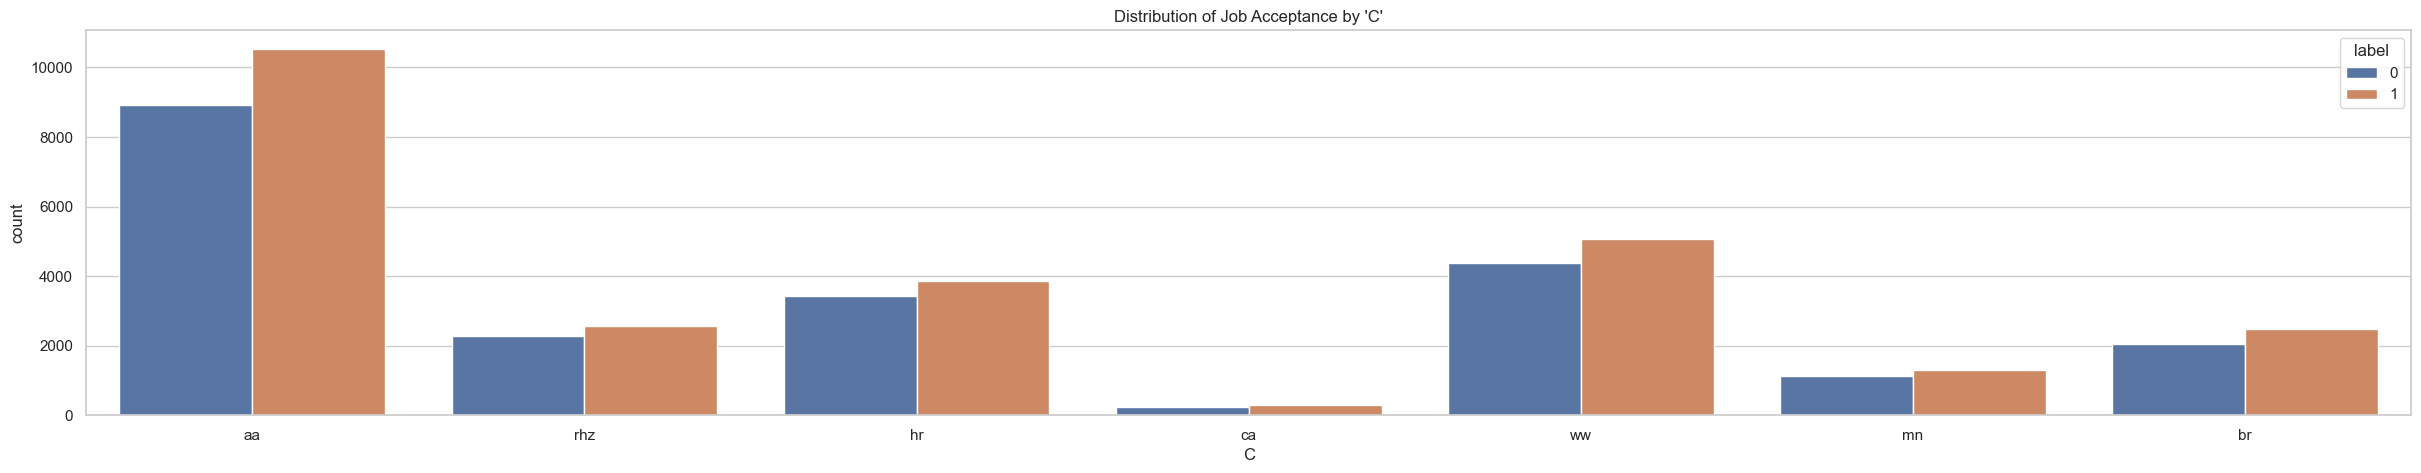

In [808]:
plt.figure(figsize=(30,5))
plt.title("Distribution of Job Acceptance by 'C'")
ax = sns.countplot(x='C', hue="label",data=data)
# C_mean = data.groupby('C')['label'].mean()
# data['C'] = data['C'].map(C_mean)
# overall_C_mean = data['C'].mean()
# data['C'].fillna(overall_C_mean, inplace = True)
# #print(data['C'])
plt.show()

Handling Categorical Features:
as seen before we used target encoding to replace all cateogrys with the mean label values related to them.

the implemention is later on in the note book under the "target encoding" title

In [809]:
#Convert all non-null values to 1 and null values to 0
#data['stack_experience'] = data['stack_experience'].apply(lambda x: 1 if pd.notnull(x)else 0)
#plt.figure(figsize=(10,5))
#ax = sns.countplot(x="stack_experience", hue="label",data=data)
#plt.show()


in this block we tried initially to get an auc value, get the model running and then check how each feature handling affects the model. later, we decided for 'stack experience' to handle the data differently, and it improved our auc significantly.

In [810]:
# data['stack_experience'] = data['stack_experience'].astype(str)

# #extracting each technologiy so we can do target encoding on it later
# unique_technologies = set()
# for exp in data['stack_experience']:
#     unique_technologies.update(exp.split(';'))
# unique_technologies = list(unique_technologies)

# #calculating mean target encoding for each technology
# mean_target_per_technology = {}
# for tech in unique_technologies:
#     tech_mask = data['stack_experience'].apply(lambda x: tech in x.split(';'))
#     if tech_mask.any():
#         mean_target_per_technology[tech] = data.loc[tech_mask, 'label'].mean()
#     else:
#         mean_target_per_technology[tech] = 0

# #compute candidate scores - all target encoding mean values sum up to a score - bigger score more valuable work experience
# def compute_score(row):
#     technologies = row['stack_experience'].split(';')
#     score = sum(mean_target_per_technology.get(tech, 0) for tech in technologies)
#     return score

# #update 'stack_experience' column with scores
# data['stack_experience'] = data.apply(compute_score, axis=1)

# print("Updated DataFrame:")
# print(data.shape)


Handling Categorical Features:
'stack experience' was hard to approach, at the beggining we just divided to 0 and 1, have / dont have experience.
we knew that its an important feature, but we could easily increase the model dimensionalty and get to over fitting, thats why we chose "target encoding" that will not affect dimensinalty but will still give a proper solution, after doing that the auc improved significantly.
the implemention is later on in the note book under the "target encoding" title

In [811]:
# !pip install pycountry-convert pycountry pytz iso3166
# import pycountry_convert as pc

# def country_to_continent(country_name):
#     if pd.isna(country_name):
#         return np.nan  # Return NaN if the country name is missing
#     try:
#         country_alpha2 = pc.country_name_to_country_alpha2(country_name)
#         country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
#         country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
#         return country_continent_name
#     except Exception as e:
#         print(f"Error converting '{country_name}': {e}")
#         return None  # Return None if the conversion fails

# # Apply the conversion to continent names
# data['continent'] = data['country'].apply(country_to_continent)

# # Print the result to check the output
# print(data[['country', 'continent']].head(20))  # Check the first 20 entries



here we tried to use a prepared library to convert country names to continents, it didnt work, and we tried several ways, including trying to import an api from kaggle and more...
at the end we built our own using a csv file with the proper country encoding as our project data.

In [812]:
#Country_mean = data.groupby('country')['label'].mean() #giving each label a number regarding its mean label value in tho whole dataset
#data['country'] = data['country'].map(Country_mean)
#overall_Country_mean = data['country'].mean()
#data['country'].fillna(overall_Country_mean, inplace = True)

we tought we would use target encoding but by looking at the data and understanding some states almost have no candidates it would affect the model.

In [813]:
# Instead of uploading the file manually, we used kaggle API to do it 'automatically'
# Load the CSV file with the appropriate encoding
# cont_data = pd.read_csv('countryContinent.csv', encoding='ISO-8859-1')

In [814]:
# # Load the CSV file with the appropriate encoding
# # cont_data = pd.read_csv('countryContinent.csv', encoding='ISO-8859-1')
# import os
# import json
# import kaggle

# proj_folder = 'Ziv_Nitazn_proj'
# # Assuming you've manually placed 'kaggle.json' in the current directory
# kaggle_json_path = os.path.expanduser('~/.kaggle/kaggle.json')
# with open (kaggle_json_path, 'r') as file:
#     kaggle_json = json.load(file)
# print(kaggle_json['username'])
# cont_data = 'statchaitya/country-to-continent'
# if not os.path.exists(proj_folder):
#     os.makedirs(proj_folder)


# kaggle.api.dataset_download_files(cont_data, path=proj_folder, force=True, unzip=True)

reading the country co continet file from kaggle in gogle colab invironment

In [815]:
# from google.colab import files
# uploaded = files.upload()  # Store the result

# import os
# import shutil
# import zipfile

# # Check if files were uploaded
# if uploaded:
#     # Create the .kaggle directory if it doesn't exist
#     os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)

#     # Iterate through uploaded files and move them to .kaggle
#     for filename in uploaded.keys():
#         shutil.move(filename, os.path.expanduser('~/.kaggle/' + filename))

#     # Set the appropriate permissions
#     os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)

#     # Correct the dataset download command
#     !kaggle datasets download KRAZYDAWG/country-to-continent

# else:
#     print("No files were uploaded.")


In [816]:
cont_data = pd.read_csv('countryContinent.csv', encoding='ISO-8859-1')


In [817]:
def map_country_to_continent(X):
    X_processed = X.copy()
    country_to_continent_dict = {}
    for i in range(len(cont_data['country'])):
        country_to_continent_dict[cont_data['country'][i]] = cont_data['sub_region'][i]
    # Replace country names with continent codes
    X_processed['country'] = X_processed['country'].map(country_to_continent_dict)
    return X_processed
data = map_country_to_continent(data)
data.head(3)

,worked_in_the_past,age_group,disability,is_dev,education,sex,mental_issues,years_of_experience,A,B,C,D,country,prev_salary,stack_experience,label
0,1.0,0.0,1.0,1.0,NaN,1.0,0.0,13.0,-1.093080,1.0,aa,180.984266,NaN,67104.0,Bash/Shell;Java;JavaScript;PowerShell;Python;T...,1
1,1.0,0.0,1.0,-1.0,other,1.0,1.0,7.0,5.444533,7.0,rhz,180.677533,Northern America,101000.0,Bash/Shell;JavaScript;PowerShell;Python;Docker...,0
2,1.0,1.0,1.0,1.0,other,1.0,1.0,25.0,1.727255,15.0,aa,177.746162,Northern America,70000.0,Bash/Shell;HTML/CSS;Java;JavaScript;PHP;SQL;Gi...,0


In [818]:

# Create a dictionary to map countries to continents
# country_to_continent_dict = {}
# for i in range(len(cont_data['country'])):
#     country_to_continent_dict[cont_data['country'][i]] = cont_data['sub_region'][i]

# # Replace country names with continent codes
# data['country'] = data['country'].map(country_to_continent_dict)

# If any country names were not found in the dictionary

#data['country'].fillna('Unknown', inplace=True)

# Display the updated DataFrame
# Country_mean = data.groupby('country')['label'].mean() #giving each label a number regarding its mean label value in tho whole dataset
# data['country'] = data['country'].map(Country_mean)
# overall_Country_mean = data['country'].mean()
# data['country'].fillna(overall_Country_mean, inplace = True)
# print(data['country'])


Handling Categorical Features:
in this section we changed each country to a sub - continent and used target encoding, we wanted to avoid over-fitting, for example in countries which we had not much data on we could easily be in overfitting. by dividing to continents we still achieve the area affect on the data.
Handeling missing values:
we calculated the mean value and replaced with nulls.

Overfitting in the model can suggest high-dimensional data. A sign for overfitting is when the model performs well on training data but poorly on unseen data. 

Why Too Many Dimensions is a Problem?

Overfitting:
"More features make each sample more unique"(Dor Bank, 2024), and will it will damage the model's ability to generalize

High-dimensional datasets increase the risk of overfitting because the model can learn noise and spurious patterns instead of the true underlying relationships. This results in poor generalization to new data
Computational Complexity:
Increased dimensions lead to higher computational costs in terms of memory and processing power. Algorithms become slower and more resource-intensive.

later, we will show that there is no significant mse difference between running the model on the train data and running the model on the validation data

## target encoding
below we defined and apllyed a function that preform target encoding on some of the categorial features.
this function return the data set after converting the values and a dictionary with the mean vaule of each category (of each feature) to use on the test dataset

In [819]:
def fit_target_encode_and_fill_nulls(data, target_col, categorical_cols):
    mappings = {}
    numeric_means = {}

    # Handle regular categorical columns
    for col in categorical_cols:
        means = data.groupby(col)[target_col].mean()
        data[col] = data[col].map(means)  # This modifies the DataFrame in place
        mappings[col] = means.to_dict()

    # Fill null values with the mean value of each numeric column
    for col in data.columns:
        if col != target_col and pd.api.types.is_numeric_dtype(data[col]):
            mean_value = data[col].mean()
            numeric_means[col] = mean_value 
            data[col].fillna(mean_value, inplace=True)  # This modifies the DataFrame in place
    
    return mappings, numeric_means


In [820]:
mappings, numeric_means = fit_target_encode_and_fill_nulls(data, 'label', ['education', 'C', 'country'])


In [821]:
mappings

{'education': {'BA/BSc': 0.5596524941948915,
  'High school': 0.59463850528026,
  'MA/MSc': 0.49128163921253515,
  'Phd': 0.2758834469931804,
  'other': 0.5857203933304831},
 'C': {'aa': 0.5417073546795498,
  'br': 0.5475874280655157,
  'ca': 0.5355805243445693,
  'hr': 0.5289029246189757,
  'mn': 0.5316872427983539,
  'rhz': 0.5268373245251858,
  'ww': 0.5368999788538803},
 'country': {'Australia and New Zealand': 0.5591958302308265,
  'Caribbean': 0.635036496350365,
  'Central America': 0.5988372093023255,
  'Central Asia': 0.43,
  'Eastern Africa': 0.6227758007117438,
  'Eastern Asia': 0.45018450184501846,
  'Eastern Europe': 0.47943037974683544,
  'Melanesia': 1.0,
  'Middle Africa': 0.6521739130434783,
  'Northern Africa': 0.5994623655913979,
  'Northern America': 0.5487597385152682,
  'Northern Europe': 0.5202370872142252,
  'South America': 0.5480925986305837,
  'South-Eastern Asia': 0.5852272727272727,
  'Southern Africa': 0.6442307692307693,
  'Southern Asia': 0.52652058160966

In [822]:
numeric_means

{'worked_in_the_past': 0.8861793662548232,
 'age_group': 0.3301112756752543,
 'disability': 0.9723796234945628,
 'is_dev': 0.842070546049811,
 'education': 0.5382252911470679,
 'sex': 0.9419637525821414,
 'mental_issues': 0.22527039404451027,
 'years_of_experience': 12.926218965584441,
 'A': 3.8502647076751124,
 'B': 7.907705499473828,
 'C': 0.5373423460555601,
 'D': 179.58057539191083,
 'country': 0.5365252851435549,
 'prev_salary': 64633.00719101999}

In [823]:

def process_stack_experience(data, stack_experience_col, target_col):
    # Convert stack_experience to string
    data[stack_experience_col] = data[stack_experience_col].astype(str)

    # Extract unique technologies
    unique_technologies = set()
    for exp in data[stack_experience_col]:
        unique_technologies.update(exp.split(';'))
    unique_technologies = list(unique_technologies)

    # Calculate mean target encoding for each technology
    mean_target_per_technology = {}
    for tech in unique_technologies:
        tech_mask = data[stack_experience_col].apply(lambda x: tech in x.split(';'))
        if tech_mask.any():
            mean_target_per_technology[tech] = data.loc[tech_mask, target_col].mean()
        else:
            mean_target_per_technology[tech] = 0

    # Compute candidate scores and update the column in place
    def compute_score(row):
        technologies = row[stack_experience_col].split(';')
        score = sum(mean_target_per_technology.get(tech, 0) for tech in technologies)
        return score

    data[stack_experience_col] = data.apply(compute_score, axis=1)

    print("Updated DataFrame:")
    print(data.shape)
    
    return mean_target_per_technology


In [824]:
stack_exp_mappings = process_stack_experience(data, 'stack_experience', 'label')

Updated DataFrame:
(51314, 16)


In [825]:
stack_exp_mappings

{'PHP': 0.6654429760156633,
 'Kubernetes': 0.6235446313065977,
 'Flask': 0.5974278087842757,
 'C': 0.5870083432657927,
 'ASP.NET': 0.8625837320574162,
 'APL': 0.40625,
 'COBOL': 0.7013888888888888,
 'SAS': 0.6419753086419753,
 'MongoDB': 0.8525599481529488,
 'React.js': 0.7198845511165123,
 'Ansible': 0.5955770978491366,
 'LISP': 0.5880681818181818,
 'Google Cloud': 0.6855934762911507,
 'Git': 0.5138645883039076,
 'Swift': 0.562467053241961,
 'Oracle': 0.6837276677933366,
 'Terraform': 0.6053670086819258,
 'Cassandra': 0.6485587583148559,
 'Colocation': 0.7461538461538462,
 'Assembly': 0.6593115622241836,
 'Ruby on Rails': 0.476734693877551,
 'Bash/Shell': 0.6944867772299417,
 'Haskell': 0.6194852941176471,
 'Docker': 0.6044553753015183,
 'SQL': 0.6624536061791554,
 'Scala': 0.5819004524886878,
 'Heroku': 0.6809725547983054,
 'HTML/CSS': 0.6891387537204139,
 'Elixir': 0.43462897526501765,
 'Vue.js': 0.6991304347826087,
 'Microsoft Azure': 0.7292865674883267,
 'Redis': 0.659772727272727

In [826]:
data.head()

,worked_in_the_past,age_group,disability,is_dev,education,sex,mental_issues,years_of_experience,A,B,C,D,country,prev_salary,stack_experience,label
0,1.0,0.0,1.000,1.0,0.538225,1.0,0.0,13.0,-1.093080,1.0,0.541707,180.984266,0.536525,67104.0,8.455183,1
1,1.0,0.0,1.000,-1.0,0.585720,1.0,1.0,7.0,5.444533,7.0,0.526837,180.677533,0.548760,101000.0,4.547449,0
2,1.0,1.0,1.000,1.0,0.585720,1.0,1.0,25.0,1.727255,15.0,0.541707,177.746162,0.548760,70000.0,8.040595,0
3,1.0,0.0,0.972,1.0,0.585720,1.0,0.0,10.0,17.804302,7.0,0.541707,176.952584,0.549823,40956.0,12.421976,0
4,1.0,0.0,1.000,1.0,0.559652,1.0,0.0,12.0,-8.679091,4.0,0.528903,179.393259,0.548760,101509.0,3.813742,0


In [827]:
data.head()


,worked_in_the_past,age_group,disability,is_dev,education,sex,mental_issues,years_of_experience,A,B,C,D,country,prev_salary,stack_experience,label
0,1.0,0.0,1.000,1.0,0.538225,1.0,0.0,13.0,-1.093080,1.0,0.541707,180.984266,0.536525,67104.0,8.455183,1
1,1.0,0.0,1.000,-1.0,0.585720,1.0,1.0,7.0,5.444533,7.0,0.526837,180.677533,0.548760,101000.0,4.547449,0
2,1.0,1.0,1.000,1.0,0.585720,1.0,1.0,25.0,1.727255,15.0,0.541707,177.746162,0.548760,70000.0,8.040595,0
3,1.0,0.0,0.972,1.0,0.585720,1.0,0.0,10.0,17.804302,7.0,0.541707,176.952584,0.549823,40956.0,12.421976,0
4,1.0,0.0,1.000,1.0,0.559652,1.0,0.0,12.0,-8.679091,4.0,0.528903,179.393259,0.548760,101509.0,3.813742,0


In [828]:
# Function to fit and scale training data, returning the fitted scaler and transformed data
def scale_numeric_columns_train(X, label_col=None):
    scaler = StandardScaler()
    # Select numeric columns excluding the label column, if specified
    if label_col:
        numeric_cols = X.select_dtypes(include=np.number).columns.difference([label_col])
    else:
        numeric_cols = X.select_dtypes(include=np.number).columns

    # Fit and transform only the selected numeric columns
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
    return X, scaler, numeric_cols

In [829]:
# Function to apply the fitted scaler to other datasets (e.g., test data)
def apply_scale_numeric_columns(X, scaler, numeric_cols):
    # Ensure that only the same numeric columns are scaled
    X[numeric_cols] = scaler.transform(X[numeric_cols])
    return X


In [830]:
data.head()

,worked_in_the_past,age_group,disability,is_dev,education,sex,mental_issues,years_of_experience,A,B,C,D,country,prev_salary,stack_experience,label
0,1.0,0.0,1.000,1.0,0.538225,1.0,0.0,13.0,-1.093080,1.0,0.541707,180.984266,0.536525,67104.0,8.455183,1
1,1.0,0.0,1.000,-1.0,0.585720,1.0,1.0,7.0,5.444533,7.0,0.526837,180.677533,0.548760,101000.0,4.547449,0
2,1.0,1.0,1.000,1.0,0.585720,1.0,1.0,25.0,1.727255,15.0,0.541707,177.746162,0.548760,70000.0,8.040595,0
3,1.0,0.0,0.972,1.0,0.585720,1.0,0.0,10.0,17.804302,7.0,0.541707,176.952584,0.549823,40956.0,12.421976,0
4,1.0,0.0,1.000,1.0,0.559652,1.0,0.0,12.0,-8.679091,4.0,0.528903,179.393259,0.548760,101509.0,3.813742,0


## Applying the preprocessing on the test data set

In [831]:
test_data = pd.read_csv('test.csv')  
test_data.head(2)

,ID,worked_in_the_past,age_group,disability,is_dev,education,sex,mental_issues,years_of_experience,A,B,C,D,country,prev_salary,stack_experience
0,48786,F,young,No,developer,BA/BSc,Male,No,5.0,9.731222,3.0,aa,178.596322,United States of America,60000.0,C#;HTML/CSS;JavaScript;SQL;ASP.NET Core ;Blazo...
1,53074,T,old,No,non-developer,other,Male,No,5.0,-2.482247,NaN,aa,179.067238,NaN,27264.0,Bash/Shell;HTML/CSS;JavaScript;Python;Docker;D...


In [832]:
# Function to apply target encoding and fill nulls on test data using mappings from training data
def apply_target_encoding(test_data, categorical_cols, mappings, numeric_means):
    # Apply the mapping to the categorical columns
    for col in categorical_cols:
        if col in mappings:
            test_data[col] = test_data[col].map(mappings[col])
    
    # Fill NaN values in numeric columns using the stored training means
    for col in categorical_cols:
        if col in test_data.columns:
            test_data[col].fillna(numeric_means[col], inplace=True) 
    
    return test_data


In [833]:
def apply_stack_experience_encoding(test_data, stack_experience_col, mean_target_per_technology):
    # Convert stack_experience to string
    test_data[stack_experience_col] = test_data[stack_experience_col].astype(str)

    # Compute candidate scores based on the dictionary from training data
    def compute_score(row):
        technologies = row[stack_experience_col].split(';')
        score = sum(mean_target_per_technology.get(tech, 0) for tech in technologies)
        return score

    # Update stack_experience column with the computed scores
    test_data[stack_experience_col] = test_data.apply(compute_score, axis=1)

    return test_data

In [834]:
def map_country_to_continent(X):
    country_to_continent_dict = {}
    for i in range(len(cont_data['country'])):
        country_to_continent_dict[cont_data['country'][i]] = cont_data['sub_region'][i]
    # Replace country names with continent codes
    X['country'] = X['country'].map(country_to_continent_dict)
    return X


# Parts 3 and 4: Model Tests and Assessments


The code in the two below will also apears in part 5, as part of the finale modle's pipline:

In [847]:
map_country_to_continent(test_data)
test_data = apply_target_encoding(test_data,['education', 'C', 'country'], mappings, numeric_means)
test_data = apply_stack_experience_encoding(test_data, 'stack_experience', stack_exp_mappings)
test_data = drop_column(test_data, ['ID'])
# Fit and scale the training data, and get the list of scaled columns
data, fitted_scaler, numeric_cols_train = scale_numeric_columns_train(data, label_col='label')


In [844]:
test_data = apply_process_disability(test_data, disability_mean)
test_data = apply_process_is_dev(test_data, is_dev_mean)
test_data = apply_process_sex(test_data, sex_mean)
test_data = apply_process_mental_issues(test_data, mental_issues_mean)
test_data = apply_worked_in_the_past(test_data, worked_in_the_past_mean)
test_data = apply_fill_nulls_with_mean(test_data, precomputed_means, ['A', 'D'])
test_data = apply_fill_nulls_with_median(test_data, precomputed_medians, ['B','prev_salary', 'years_of_experience'])
test_data = apply_process_age_group(test_data, age_group_mean)
test_data = apply_scale_numeric_columns(test_data, fitted_scaler, numeric_cols_train)

In [845]:
test_data.head(5)

,worked_in_the_past,age_group,disability,is_dev,education,sex,mental_issues,years_of_experience,A,B,C,D,country,prev_salary,stack_experience
0,-2.835705,-0.719006,0.174505,0.298456,3.684234e-01,0.267234,-0.551331,-1.000801,0.984680,-0.788935,0.702800,-0.934550,4.172922e-01,-0.099634,-0.035948
1,0.364217,1.459067,0.174505,-3.481156,8.166399e-01,0.267234,-0.551331,-1.000801,-1.060286,-0.306672,0.702800,-0.487415,-3.786744e-15,-0.803632,-0.234259
2,0.364217,-0.000242,0.174505,0.298456,1.908939e-15,0.267234,-0.551331,0.893168,0.689644,1.140117,0.000000,0.765080,4.535425e-01,-0.162602,-1.140576
3,0.364217,1.459067,-0.002398,0.298456,3.684234e-01,0.267234,-0.551331,0.893168,-1.254936,-0.306672,-0.910515,1.660904,-3.786744e-15,1.193416,3.011431
4,-2.835705,1.459067,0.174505,0.298456,8.166399e-01,0.267234,-0.551331,3.418461,-1.528320,4.194448,0.702800,0.169225,-5.555572e-01,-0.162602,0.248572


In [846]:
test_data_missing_values_count = test_data.isnull().sum()
print(test_data_missing_values_count)

worked_in_the_past     0
age_group              0
disability             0
is_dev                 0
education              0
sex                    0
mental_issues          0
years_of_experience    0
A                      0
B                      0
C                      0
D                      0
country                0
prev_salary            0
stack_experience       0
dtype: int64


## Dimensionality reduction - PCA

calculating auc before preforming pca

חלק 2 - האם הדאטה מנורמלים? אם לא - האם צריך לנרמל אותם? מה חשיבות של נרמול הנתונים בבעיה.
the data we received wasn't normallized, some of the features were categorial features and some of them were continuous and spanning over a large scale of numbers such as prev salary. yes, the data needs to be normallized.
scaling the data is importance for several reasons, such as equal weighthings of features, we want to make sure, prior to the running phase that all the features will equally contribute to the result (related later also for gradient decent calc). particuallry in KNN models that rely on distance, in the abscence of normallization large feature will have a bigger affect on the results.
normallizing is also important for consistent regularization, all the features will pass through regularization, and different scales of numbers will be affected differently from that regularization.
another short example is the affect on gradient decent, while calculating the gradient large scale numbers will "pull" to their direction so by trying to minimize the loss function of 2 features fot example we will have a gradient that mostly affected and minimizing loss for only 1 of the features.

In [434]:
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, RocCurveDisplay,mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

Ensure there are no NaNs in the data before running models and performing the PCA

In [435]:
missing_values_count = data.isnull().sum()
print(missing_values_count)

worked_in_the_past     0
age_group              0
disability             0
is_dev                 0
education              0
sex                    0
mental_issues          0
years_of_experience    0
A                      0
B                      0
C                      0
D                      0
country                0
prev_salary            0
stack_experience       0
label                  0
dtype: int64


Split the data into train data and validation data

In [436]:
X = data.iloc[:, :-1].values  # All columns except the lables' column
Y = data.iloc[:, -1].values   # Only the labels' column
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2, random_state = 42)


Logistic Regression model

In [437]:
# # Define the model
# clf = LogisticRegression()

# # Define the parameter grid
# param_grid = {
#     'penalty': ['l2','l1'],
#     'C': [0.001,0.01, 0.1, 1],
#     'solver': ['saga','liblinear'],
#     'max_iter': [100, 200,300,400,500]
# }

# # Create the GridSearchCV object
# optimizer_lr = GridSearchCV(clf, param_grid, scoring='roc_auc', n_jobs=-1, cv=5)
# Xlr = X_train
# ylr = y_train
# optimizer_lr.fit(Xlr, ylr)

# # Get the best parameters and the best score
# best_params = optimizer_lr.best_params_
# best_score = optimizer_lr.best_score_

# print("Best Parameters:", best_params)
# print("Best ROC AUC Score:", best_score)

In [438]:
Xlr = X_train
ylr = y_train
best_params = {
    'penalty': 'l2',
    'C': 0.01,
    'solver': 'liblinear',
    'max_iter': 100
}
best_model_lr = LogisticRegression(**best_params)

In [439]:
kf_lr = KFold(n_splits=5, shuffle=True, random_state=42)

fpr_list_lr = []
tpr_list_lr = []
auc_list_lr = []
roc_aucs_train_lr = []
roc_aucs_val_lr = []

# Perform K-Fold Cross-Validation
for train_index, val_index in kf_lr.split(Xlr):
    Xlr_train, Xlr_val = Xlr[train_index], Xlr[val_index]
    ylr_train, ylr_val = ylr[train_index], ylr[val_index]

    # Fit the model
    best_model_lr.fit(Xlr_train, ylr_train)

    # Predict probabilities
    y_proba_train = best_model_lr.predict_proba(Xlr_train)[:, 1]
    y_proba_val = best_model_lr.predict_proba(Xlr_val)[:, 1]

    # Compute ROC curve and AUC for the validation set
    fpr, tpr, _ = roc_curve(ylr_val, y_proba_val)
    roc_auc = auc(fpr, tpr)

    # Compute AUC for the training set
    roc_auc_train = roc_auc_score(ylr_train, y_proba_train)
    # Compute AUC for the validation set
    roc_auc_val = roc_auc_score(ylr_val, y_proba_val)

    # Store results
    fpr_list_lr.append(fpr)
    tpr_list_lr.append(tpr)
    auc_list_lr.append(roc_auc)
    roc_aucs_train_lr.append(roc_auc_train)
    roc_aucs_val_lr.append(roc_auc_val)

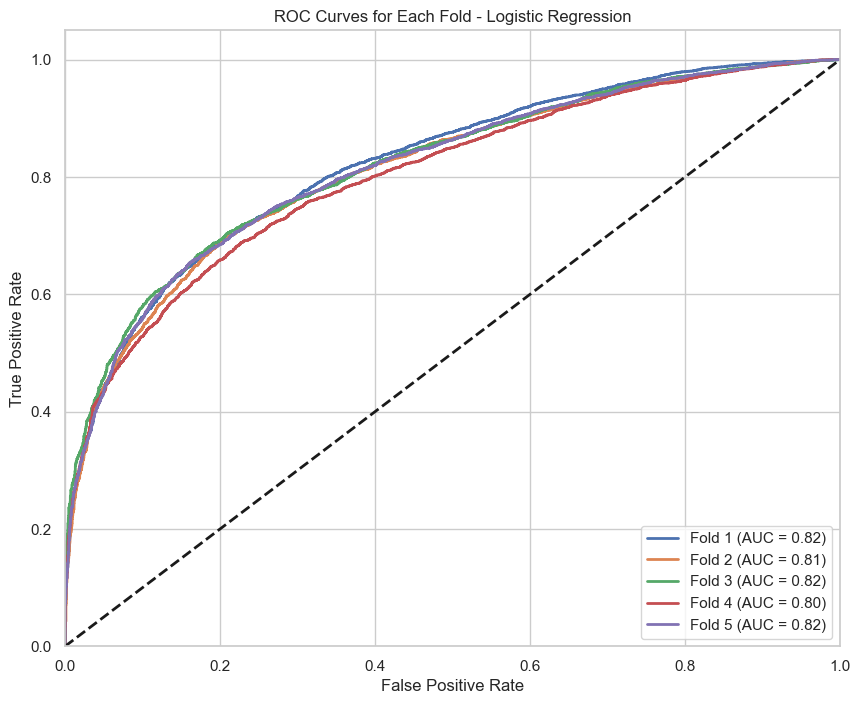

In [440]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(fpr_list_lr)):
    plt.plot(fpr_list_lr[i], tpr_list_lr[i], lw=2, label=f'Fold {i+1} (AUC = {auc_list_lr[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Fold - Logistic Regression')
plt.legend(loc='lower right')
plt.show()


We see stabilized predictions over the validation sets.

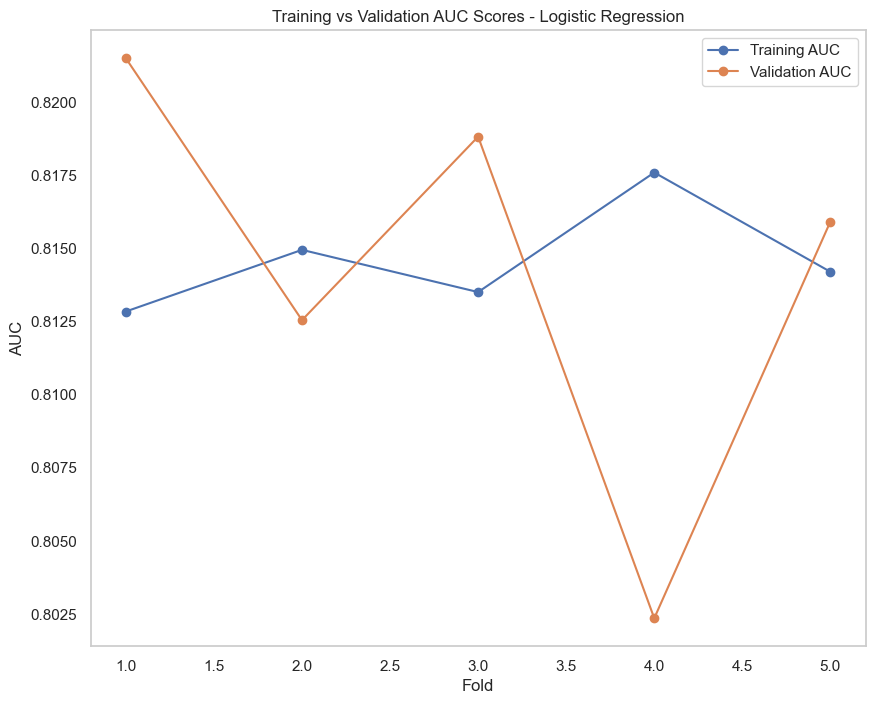

In [441]:
plt.figure(figsize=(10, 8))
plt.plot(range(1, kf_lr.get_n_splits() + 1), roc_aucs_train_lr, marker='o', label='Training AUC')
plt.plot(range(1, kf_lr.get_n_splits() + 1), roc_aucs_val_lr, marker='o', label='Validation AUC')
plt.xlabel('Fold')
plt.ylabel('AUC')
plt.title('Training vs Validation AUC Scores - Logistic Regression')
plt.legend()
plt.grid()
plt.show()

We see that the validation score and the train score are almost the same which indicates we are balanced and not overfitted.

In [442]:
# Train the best model on the entire training set
best_model_lr.fit(X_train, y_train)

# Make predictions on the training and test data
y_proba_train_lr = best_model_lr.predict_proba(X_train)[:, 1]
y_proba_test_lr = best_model_lr.predict_proba(X_test)[:, 1]

# Compute AUC for training and test data
auc_train_lr = roc_auc_score(y_train, y_proba_train_lr)
auc_test_lr = roc_auc_score(y_test, y_proba_test_lr)

print(f"ROC AUC on Training Set (Logistic Regression): {auc_train_lr:.4f}")
print(f"ROC AUC on Test Set (Logistic Regression): {auc_test_lr:.4f}")

ROC AUC on Training Set (Logistic Regression): 0.8146
ROC AUC on Test Set (Logistic Regression): 0.8143


Below is the feature correlation matrix for our dataset before applying PCA.

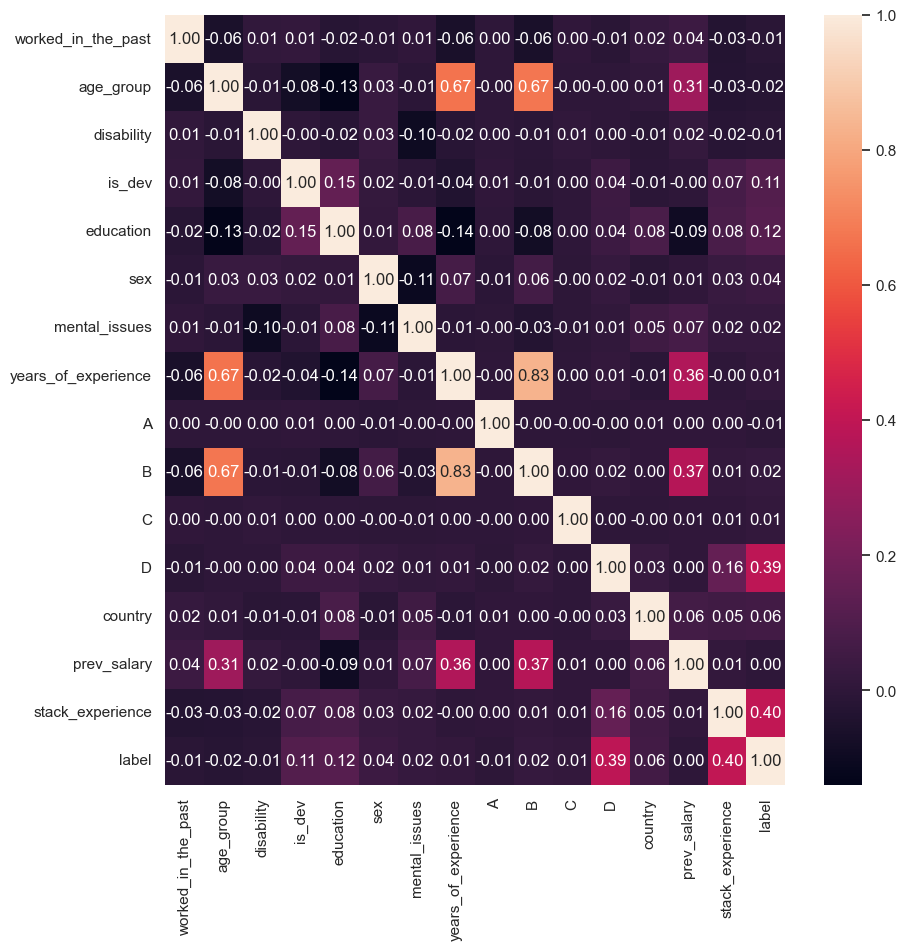

In [443]:
plt.figure(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, fmt=".2f", 
            xticklabels=data.corr().columns, 
            yticklabels=data.corr().columns)
plt.show()

we see in the heat map that there is high correlation bewtween 'years of experience' and 'B', we should consider removing one of them.
we can also see negative correlation between 'age group' to 'years of experience';'prev salary' and 'B',
We decided to remove 'B' beacuse it has less meaning for us compared to 'years of experience'

Now we run another Logistic Regression model (after dropping the 'B') to compare its results to the results of the Logistic Regression model we already ran, and then after pca model we will test next.

In [444]:
data = drop_column(data, ['B'])
data.shape


(51920, 15)

In [445]:
X = data.iloc[:, :-1].values  # All columns except the lables' column
Y = data.iloc[:, -1].values   # Only the labels' column
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2, random_state = 42)

after dropping 'B' we need to split the data set again, this time without 'B'.

In [446]:
best_model_lr2 = LogisticRegression(**best_params)

kf_lr2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store ROC curve data and AUC scores
fpr_list_lr2 = []
tpr_list_lr2 = []
auc_list_lr2 = []
roc_aucs_train_lr2 = []
roc_aucs_val_lr2 = []

# Perform K-Fold Cross-Validation
for train_index, val_index in kf_lr2.split(Xlr, ylr):
    Xlr2_train, Xlr2_val = Xlr[train_index], Xlr[val_index]
    ylr2_train, ylr2_val = ylr[train_index], ylr[val_index]

    # Fit the model
    best_model_lr2.fit(Xlr2_train, ylr2_train)

    # Predict probabilities
    y_proba_train_lr2 = best_model_lr2.predict_proba(Xlr2_train)[:, 1]
    y_proba_val_lr2 = best_model_lr2.predict_proba(Xlr2_val)[:, 1]

    # Compute ROC curve for the validation set
    fpr_lr2, tpr_lr2, _ = roc_curve(ylr2_val, y_proba_val_lr2)
    roc_auc_lr2 = auc(fpr_lr2, tpr_lr2)

    # Compute AUC for the training set
    roc_auc_train_lr2 = roc_auc_score(ylr2_train, y_proba_train_lr2)
    # Compute AUC for the validation set
    roc_auc_val_lr2 = roc_auc_score(ylr2_val, y_proba_val_lr2)

    # Store results
    fpr_list_lr2.append(fpr_lr2)
    tpr_list_lr2.append(tpr_lr2)
    auc_list_lr2.append(roc_auc_lr2)
    roc_aucs_train_lr2.append(roc_auc_train_lr2)
    roc_aucs_val_lr2.append(roc_auc_val_lr2)

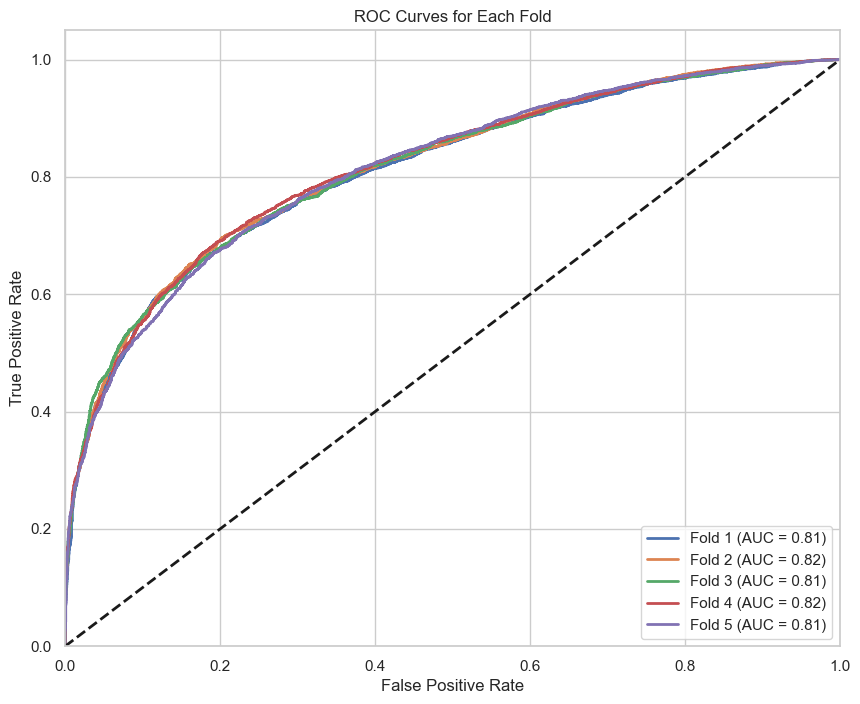

In [447]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(fpr_list_lr2)):
    plt.plot(fpr_list_lr2[i], tpr_list_lr2[i], lw=2, label=f'Fold {i+1} (AUC = {auc_list_lr2[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Fold')
plt.legend(loc='lower right')
plt.show()



we see stabilized predictions over the validation sets.

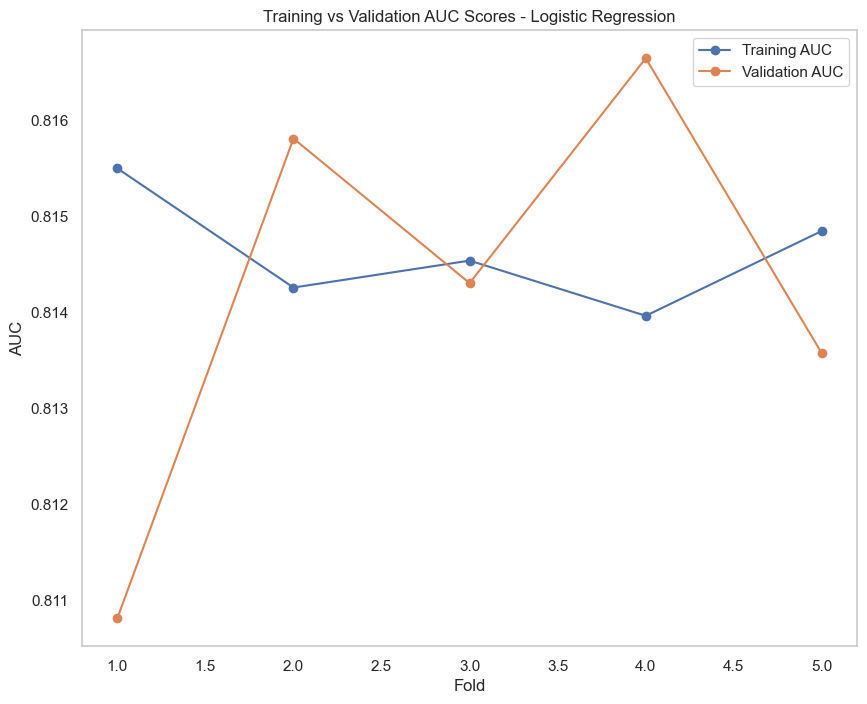

In [448]:
plt.figure(figsize=(10, 8))
plt.plot(range(1, kf_lr2.get_n_splits() + 1), roc_aucs_train_lr2, marker='o', label='Training AUC')
plt.plot(range(1, kf_lr2.get_n_splits() + 1), roc_aucs_val_lr2, marker='o', label='Validation AUC')
plt.xlabel('Fold')
plt.ylabel('AUC')
plt.title('Training vs Validation AUC Scores - Logistic Regression')
plt.legend()
plt.grid()
plt.show()

we see that the validation score and the train score are almost the same which indicates we are balanced and not overfitted.

In [449]:
# Train the best model on the entire training set
best_model_lr2.fit(X_train, y_train)

# Make predictions on the training and test data
y_proba_train_lr2 = best_model_lr2.predict_proba(X_train)[:, 1]
y_proba_test_lr2 = best_model_lr2.predict_proba(X_test)[:, 1]

# Compute AUC for training and test data
auc_train_lr2 = roc_auc_score(y_train, y_proba_train_lr2)
auc_test_lr2 = roc_auc_score(y_test, y_proba_test_lr2)

print(f"ROC AUC on Training Set (Logistic Regression): {auc_train_lr2:.4f}")
print(f"ROC AUC on Test Set (Logistic Regression): {auc_test_lr2:.4f}")

ROC AUC on Training Set (Logistic Regression): 0.8145
ROC AUC on Test Set (Logistic Regression): 0.8142


after removing 'B' and testing our model, as expected because of the high correlation, the auc was not affected, and we reduced dimensionalty in this action by one.

calculating auc after preforming pca

In [450]:

pca = PCA(n_components=0.95)  # Preserve 95% of the variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
n_of_dim = pca.n_components_
print(f"number of dimensions: {n_of_dim}")


number of dimensions: 13


In [451]:
best_model_lr_pca = LogisticRegression(**best_params)
kf_pca = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fpr_list_pca = []
tpr_list_pca = []
auc_list_pca = []
roc_aucs_train_pca = []
roc_aucs_val_pca = []

# Perform K-Fold Cross-Validation after PCA
for train_index, val_index in kf_pca.split(X_train_pca,y_train):
    X_train_pca_fold, X_val_pca_fold = X_train_pca[train_index], X_train_pca[val_index]
    y_train_pca_fold, y_val_pca_fold = y_train[train_index], y_train[val_index]

    # Fit the model
    best_model_lr_pca.fit(X_train_pca_fold, y_train_pca_fold)

    # Predict probabilities
    y_proba_train_pca = best_model_lr_pca.predict_proba(X_train_pca_fold)[:, 1]
    y_proba_val_pca = best_model_lr_pca.predict_proba(X_val_pca_fold)[:, 1]

    # Compute ROC curve for the validation set
    fpr_pca, tpr_pca, _ = roc_curve(y_val_pca_fold, y_proba_val_pca)
    roc_auc_pca = auc(fpr_pca, tpr_pca)

    # Compute AUC for the training set
    roc_auc_train_pca = roc_auc_score(y_train_pca_fold, y_proba_train_pca)
    # Compute AUC for the validation set
    roc_auc_val_pca = roc_auc_score(y_val_pca_fold, y_proba_val_pca)

    # Store results
    fpr_list_pca.append(fpr_pca)
    tpr_list_pca.append(tpr_pca)
    auc_list_pca.append(roc_auc_pca)
    roc_aucs_train_pca.append(roc_auc_train_pca)
    roc_aucs_val_pca.append(roc_auc_val_pca)

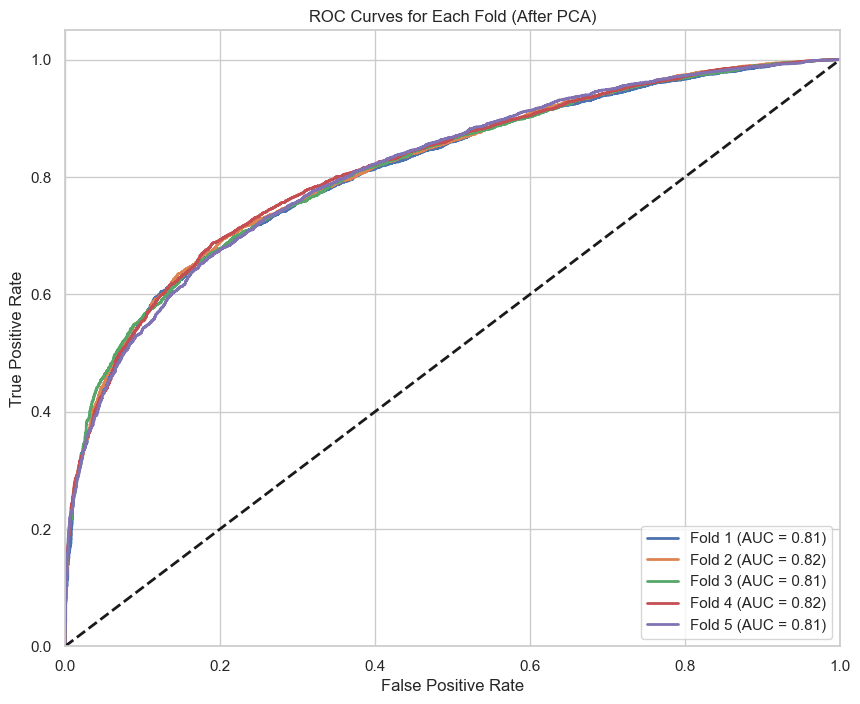

In [452]:
# Plot ROC curves after PCA
plt.figure(figsize=(10, 8))
for i in range(len(fpr_list_pca)):
    plt.plot(fpr_list_pca[i], tpr_list_pca[i], lw=2, label=f'Fold {i+1} (AUC = {auc_list_pca[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Fold (After PCA)')
plt.legend(loc='lower right')
plt.show()


we see stabilized predictions over the validation sets.

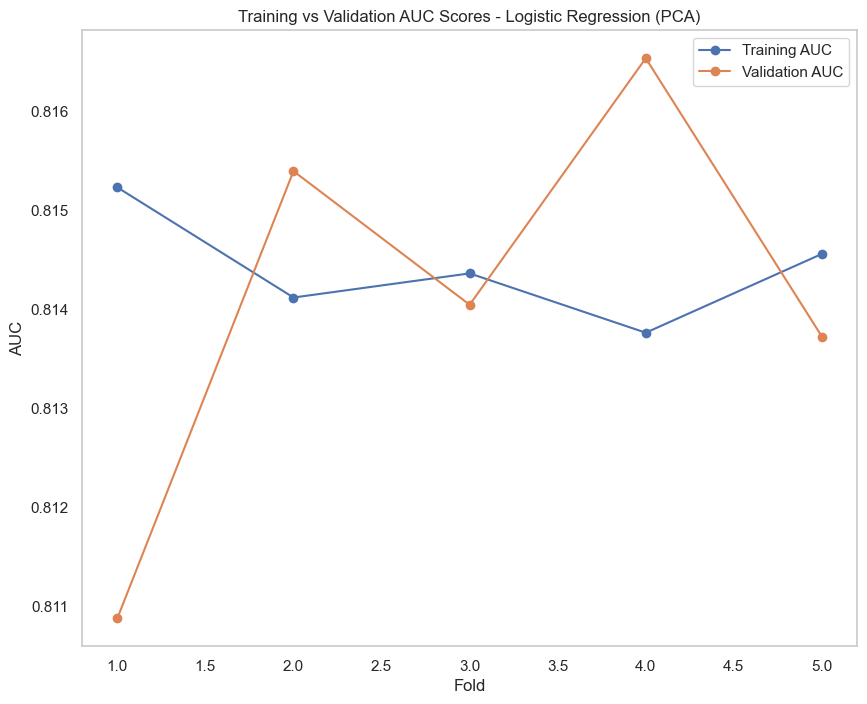

In [453]:
plt.figure(figsize=(10, 8))
plt.plot(range(1, kf_pca.get_n_splits() + 1), roc_aucs_train_pca, marker='o', label='Training AUC')
plt.plot(range(1, kf_pca.get_n_splits() + 1), roc_aucs_val_pca, marker='o', label='Validation AUC')
plt.xlabel('Fold')
plt.ylabel('AUC')
plt.title('Training vs Validation AUC Scores - Logistic Regression (PCA)')
plt.legend()
plt.grid()
plt.show()

we see that the validation score and the train score are almost the same which indicates we are not overfitted.

In [454]:
print(roc_aucs_train_pca)
print(roc_aucs_val_pca)
print(roc_aucs_train_lr2)
print(roc_aucs_val_lr2)

[0.8152325012808816, 0.8141189309936328, 0.8143629520889311, 0.8137632515731736, 0.8145598573698647]
[0.8108761845370261, 0.8153968145558499, 0.8140460031132766, 0.8165382443973377, 0.8137243841162289]
[0.8155002888685211, 0.8142578091994893, 0.8145388105822622, 0.8139634382445953, 0.8148481207866363]
[0.8108105840702025, 0.8158109740434414, 0.8143040442292262, 0.8166482090734435, 0.8135705384644433]


the lr2 model and the pca model plots of the kfolds looked the same - checked to see the vaules and to make sure there is no data leakage.
the values are almost similiar.

In [455]:
# Train the best model on the entire training set
best_model_lr_pca.fit(X_train_pca, y_train)

# Make predictions on the training and test data
y_proba_train_pca = best_model_lr_pca.predict_proba(X_train_pca)[:, 1]
y_proba_test_pca = best_model_lr_pca.predict_proba(X_test_pca)[:, 1]

# Compute AUC for training and test data
auc_train_pca = roc_auc_score(y_train, y_proba_train_pca)
auc_test_pca = roc_auc_score(y_test, y_proba_test_pca)

print(f"ROC AUC on Training Set (Logistic Regression PCA): {auc_train_pca:.4f}")
print(f"ROC AUC on Test Set (Logistic Regression PCA): {auc_test_pca:.4f}")

ROC AUC on Training Set (Logistic Regression PCA): 0.8144
ROC AUC on Test Set (Logistic Regression PCA): 0.8140


 As you can see from the results, there is not a significant improvement in the logistic regression model's AUC before and after applying PCA. we can benefit from less dimentionality (from 15 to 13) one the one hand, but loss the ability to explain our features on the other.

KNN

below we looked for the best parameters for our KNN model

In [ ]:
# param_grid_knn = {
#     'n_neighbors': [50, 100, 150, 200],     
#     'weights': ['uniform','distance'],      
#     'algorithm': ['kd_tree', 'ball_tree','brute'],    # Testing different algorithms
#     'p': [1, 2],                            # Testing both Manhattan and Euclidean distances
#     'leaf_size': [20, 30, 40]               # Testing different leaf sizes for tree-based algorithms
# }
# optimizer_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=2, scoring='roc_auc', n_jobs=-1)
# optimizer_knn.fit(X_train_pca, y_train)
# print("Best Parameters:", optimizer_knn.best_params_)
# best_score_knn = optimizer_knn.best_score_
# print("Best ROC AUC Score:", best_score_knn)

In [457]:
best_knn_params = {
    'n_neighbors': 100,
    'weights': 'uniform',
    'algorithm': 'kd_tree',
    'p': 2,  
    'leaf_size': 20
}

# Use the best parameters to initialize the best KNN model
best_knn = KNeighborsClassifier(**best_knn_params, n_jobs = -1)


In [458]:
kf_knn = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store ROC curve data
fpr_list_knn = []
tpr_list_knn = []
auc_list_knn = []
roc_aucs_train_knn = []
roc_aucs_val_knn = []

# Perform K-Fold Cross-Validation and compute ROC curves for each fold
for train_index, test_index in kf_knn.split(X_train):
    Xknn_train, Xknn_val = X_train[train_index], X_train[val_index]
    yknn_train, yknn_val = y_train[train_index], y_train[val_index]

    # Train the model
    best_knn.fit(Xknn_train, yknn_train)

    # Predict probabilities
    yknn_proba_train = best_knn.predict_proba(Xknn_train)[:, 1]
    yknn_proba_val = best_knn.predict_proba(Xknn_val)[:, 1]
    
    # Compute ROC curve
    fpr_knn, tpr_knn, _ = roc_curve(yknn_val, yknn_proba_val)
    roc_auc_knn = auc(fpr_knn, tpr_knn)
    # Compute AUC for the training set
    roc_auc_train_knn = roc_auc_score(yknn_train, yknn_proba_train)
    # Compute AUC for the validation set
    roc_auc_val_knn = roc_auc_score(yknn_val, yknn_proba_val)

    # Store results
    fpr_list_knn.append(fpr_knn)
    tpr_list_knn.append(tpr_knn)
    auc_list_knn.append(roc_auc_knn)
    roc_aucs_train_knn.append(roc_auc_train_knn)
    roc_aucs_val_knn.append(roc_auc_val_knn)


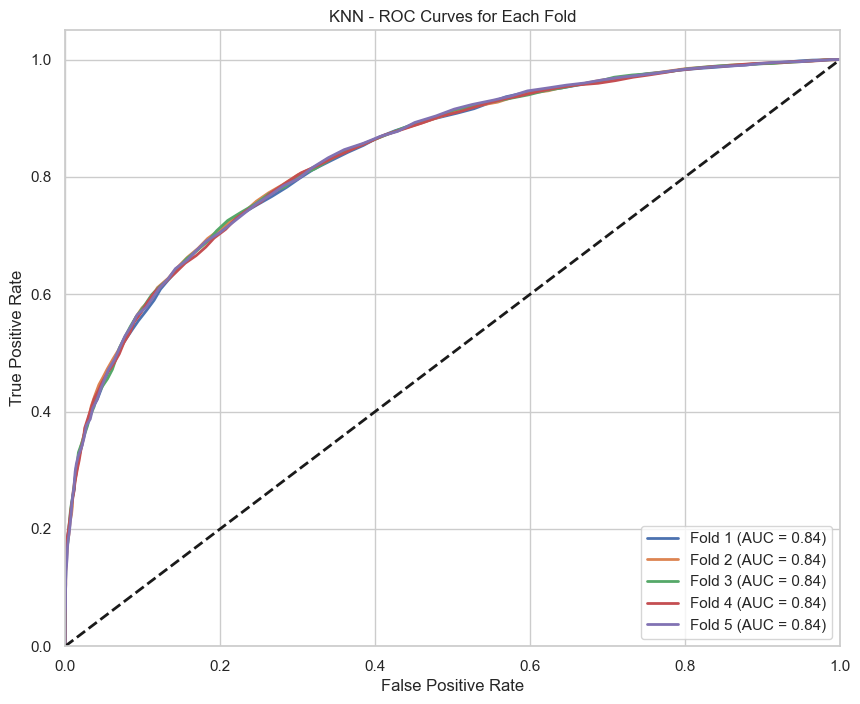

In [459]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(fpr_list_knn)):
    plt.plot(fpr_list_knn[i], tpr_list_knn[i], lw=2, label=f'Fold {i+1} (AUC = {auc_list_knn[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN - ROC Curves for Each Fold')
plt.legend(loc='lower right')
plt.show()

we see stabilized predictions over the validation sets.

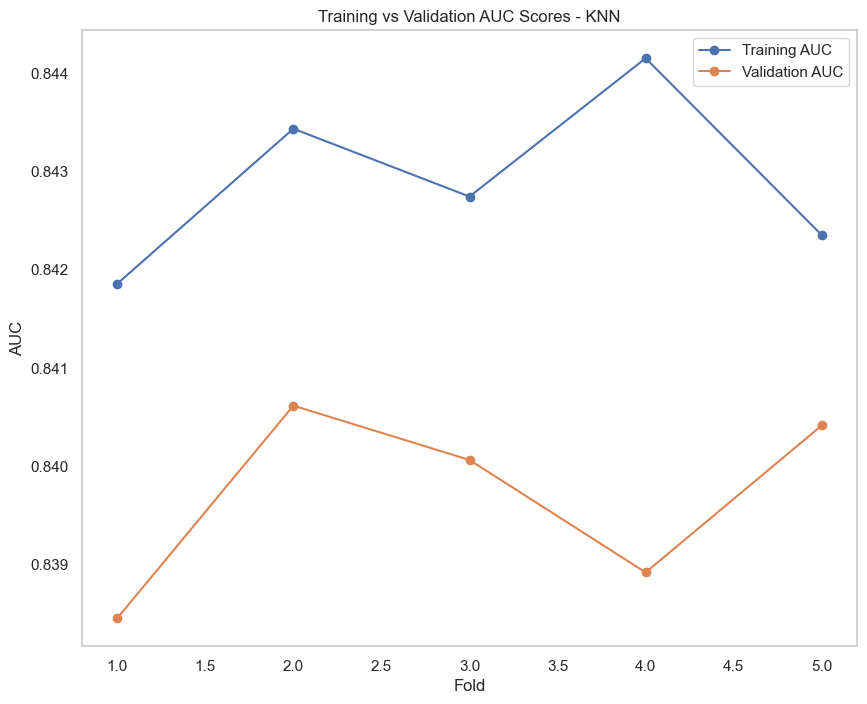

In [460]:
plt.figure(figsize=(10, 8))
plt.plot(range(1, kf_knn.get_n_splits() + 1), roc_aucs_train_knn, marker='o', label='Training AUC')
plt.plot(range(1, kf_knn.get_n_splits() + 1), roc_aucs_val_knn, marker='o', label='Validation AUC')
plt.xlabel('Fold')
plt.ylabel('AUC')
plt.title('Training vs Validation AUC Scores - KNN')
plt.legend()
plt.grid()
plt.show()

we see that the validation score and the train score are almost the same which indicates we are balanced and not overfitted.

In [461]:
# Train the best model on the entire training set
best_knn.fit(X_train, y_train)

# Make predictions on the training and test data
y_proba_train = best_knn.predict_proba(X_train)[:, 1]
y_proba_test = best_knn.predict_proba(X_test)[:, 1]

# Compute AUC for training and test data
auc_train = roc_auc_score(y_train, y_proba_train)
auc_test = roc_auc_score(y_test, y_proba_test)

print(f"ROC AUC on Training Set: {auc_train:.4f}")
print(f"ROC AUC on Test Set: {auc_test:.4f}")


ROC AUC on Training Set: 0.8450
ROC AUC on Test Set: 0.8380


Random Forest - with PCA

In [462]:
# param_grid_rf = {
#     'n_estimators': [50, 100,150, 200],
#     'max_depth': [8,10,12,15],
#     'min_samples_split': [10,15,20],
#     'min_samples_leaf': [5,10,15],
#     'bootstrap': [True, False],
#     'criterion': ['gini', 'entropy']
# }
# rf = RandomForestClassifier()
# optimizer_rf = GridSearchCV(rf, param_grid_rf, scoring='roc_auc', n_jobs=-1, cv=3, return_train_score=True)
# optimizer_rf.fit(X_train, y_train)
# print("Best Parameters for Random Forest:", optimizer_rf.best_params_)
# print("Best ROC AUC score from GridSearchCV:", optimizer_rf.best_score_)



In [463]:

# Train the best model with the best parameters
best_rf_params = {
    'n_estimators': 150,
    'max_depth': 10,
    'min_samples_split': 20,
    'min_samples_leaf': 5,
    'bootstrap': True,
    'criterion': 'entropy'
}
best_rf_pca = RandomForestClassifier(**best_rf_params, n_jobs=-1)


In [464]:
# Initialize KFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store ROC curve data
fpr_list_rf_pca = []
tpr_list_rf_pca = []
auc_list_rf_pca = []
roc_aucs_train_pca = []
roc_aucs_val_pca = []

# Perform K-Fold Cross-Validation and compute ROC curves for each fold
for train_index, val_index in kf.split(X_train_pca, y_train):
    X_train_rf, X_val_rf = X_train_pca[train_index], X_train_pca[val_index]
    y_train_rf, y_val_rf = y_train[train_index], y_train[val_index]

    # Train the model
    best_rf_pca.fit(X_train_rf, y_train_rf)

    # Predict probabilities
    y_proba_train_fold = best_rf_pca.predict_proba(X_train_rf)[:, 1]
    y_proba_val_fold = best_rf_pca.predict_proba(X_val_rf)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_val_rf, y_proba_val_fold)
    roc_auc = auc(fpr, tpr)
    roc_auc_train_fold = roc_auc_score(y_train_rf, y_proba_train_fold)
    roc_auc_val_fold = roc_auc_score(y_val_rf, y_proba_val_fold)

    # Store results
    fpr_list_rf_pca.append(fpr)
    tpr_list_rf_pca.append(tpr)
    auc_list_rf_pca.append(roc_auc)
    roc_aucs_train_pca.append(roc_auc_train_fold)
    roc_aucs_val_pca.append(roc_auc_val_fold)


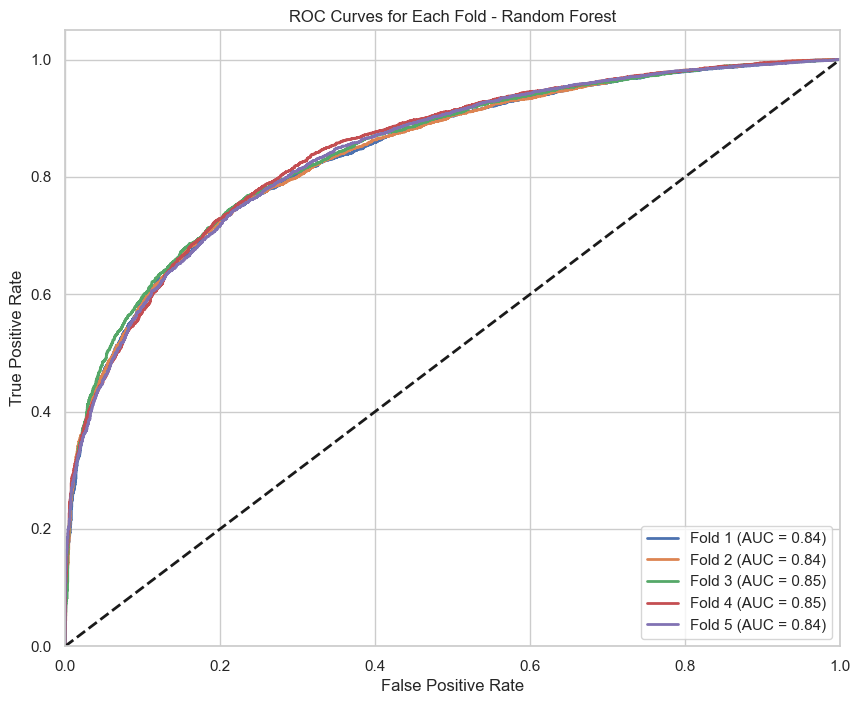

In [465]:
# Plot ROC curves for each fold
plt.figure(figsize=(10, 8))
for i in range(len(fpr_list_rf_pca)):
    plt.plot(fpr_list_rf_pca[i], tpr_list_rf_pca[i], lw=2, label=f'Fold {i+1} (AUC = {auc_list_rf_pca[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Fold - Random Forest')
plt.legend(loc='lower right')
plt.show()


we see stabilized predictions over the validation sets.

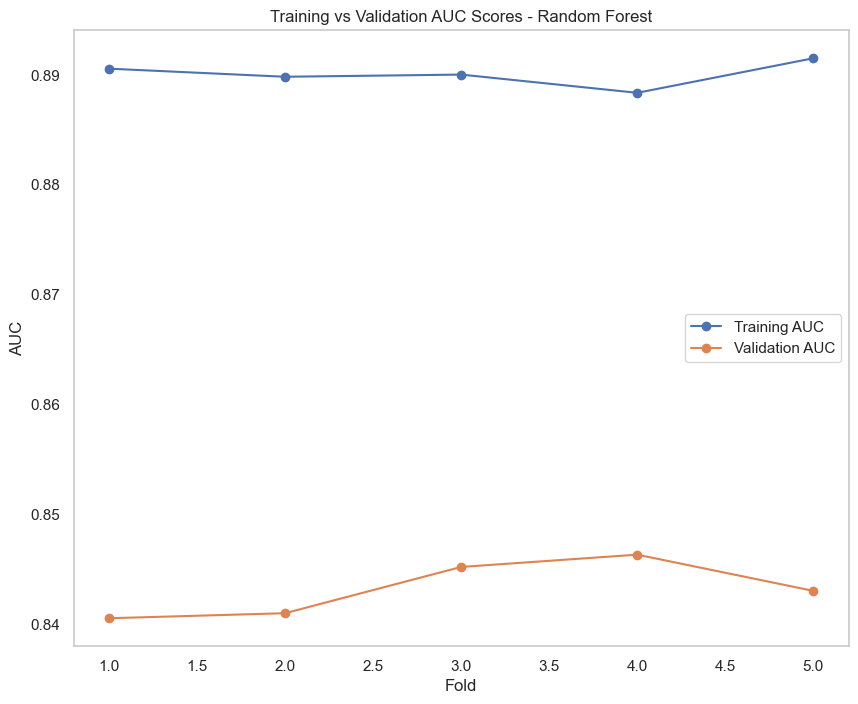

In [466]:
plt.figure(figsize=(10, 8))
plt.plot(range(1, kf.get_n_splits() + 1), roc_aucs_train_pca, marker='o', label='Training AUC')
plt.plot(range(1, kf.get_n_splits() + 1), roc_aucs_val_pca, marker='o', label='Validation AUC')
plt.xlabel('Fold')
plt.ylabel('AUC')
plt.title('Training vs Validation AUC Scores - Random Forest')
plt.legend()
plt.grid()
plt.show()

we can notice a relativly big difference between the training and validation scores, which means we slighlty overfitted, this is after using pca, so we decided to stick with non pca data for better results.

In [467]:

# Train the best model on the entire training set
best_rf_pca.fit(X_train_pca, y_train)

# Make predictions on the training and test data
y_proba_train = best_rf_pca.predict_proba(X_train_pca)[:, 1]
y_proba_test = best_rf_pca.predict_proba(X_test_pca)[:, 1]

# Compute AUC for training and test data
auc_train = roc_auc_score(y_train, y_proba_train)
auc_test = roc_auc_score(y_test, y_proba_test)

print(f"ROC AUC on Training Set: {auc_train:.4f}")
print(f"ROC AUC on Test Set: {auc_test:.4f}")

ROC AUC on Training Set: 0.8857
ROC AUC on Test Set: 0.8457


Random Forest - without PCA

In [468]:
#Define the model according to gridsearchCV results
best_rf = RandomForestClassifier(**best_rf_params, n_jobs=-1)
# Initialize KFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store ROC curve data
fpr_list_rf = []
tpr_list_rf = []
auc_list_rf = []
roc_aucs_train = []
roc_aucs_val = []

# Perform K-Fold Cross-Validation and compute ROC curves for each fold
for train_index, val_index in kf.split(X_train, y_train):
    X_train_rf, X_val_rf = X_train[train_index], X_train[val_index]
    y_train_rf, y_val_rf = y_train[train_index], y_train[val_index]

    # Train the model
    best_rf.fit(X_train_rf, y_train_rf)

    # Predict probabilities
    y_proba_train_fold = best_rf.predict_proba(X_train_rf)[:, 1]
    y_proba_val_fold = best_rf.predict_proba(X_val_rf)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_val_rf, y_proba_val_fold)
    roc_auc = auc(fpr, tpr)
    roc_auc_train_fold = roc_auc_score(y_train_rf, y_proba_train_fold)
    roc_auc_val_fold = roc_auc_score(y_val_rf, y_proba_val_fold)

    # Store results
    fpr_list_rf.append(fpr)
    tpr_list_rf.append(tpr)
    auc_list_rf.append(roc_auc)
    roc_aucs_train.append(roc_auc_train_fold)
    roc_aucs_val.append(roc_auc_val_fold)

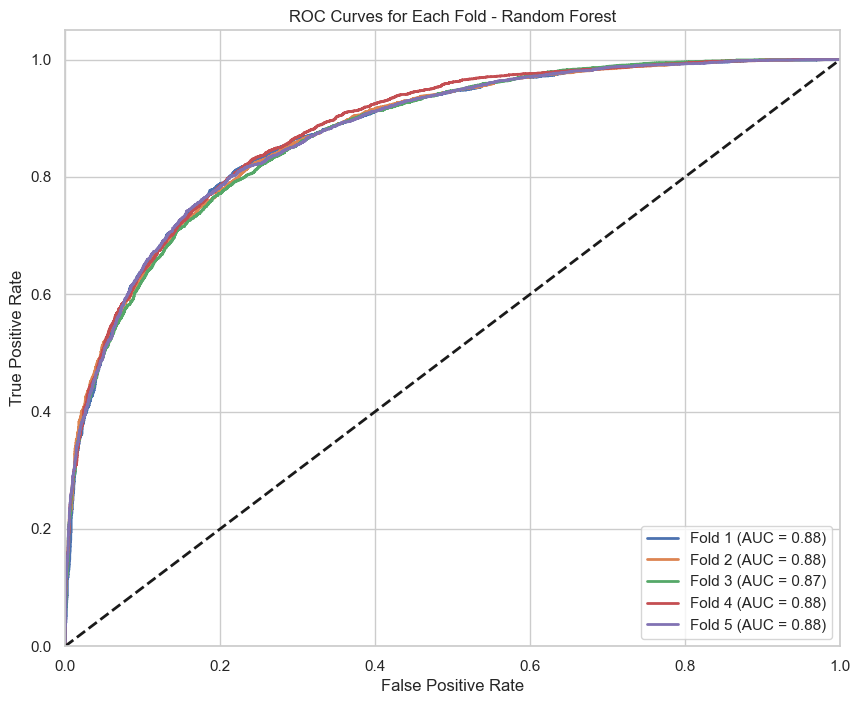

In [469]:
# Plot ROC curves for each fold
plt.figure(figsize=(10, 8))
for i in range(len(fpr_list_rf)):
    plt.plot(fpr_list_rf[i], tpr_list_rf[i], lw=2, label=f'Fold {i+1} (AUC = {auc_list_rf[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Fold - Random Forest')
plt.legend(loc='lower right')
plt.show()



we see stabilized predictions over the validation sets.

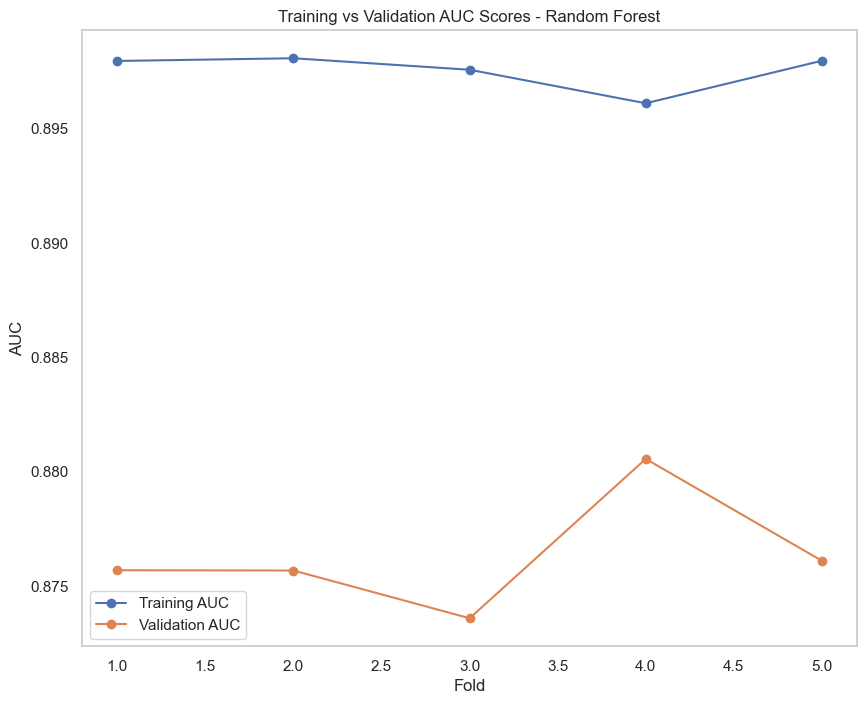

In [470]:
plt.figure(figsize=(10, 8))
plt.plot(range(1, kf.get_n_splits() + 1), roc_aucs_train, marker='o', label='Training AUC')
plt.plot(range(1, kf.get_n_splits() + 1), roc_aucs_val, marker='o', label='Validation AUC')
plt.xlabel('Fold')
plt.ylabel('AUC')
plt.title('Training vs Validation AUC Scores - Random Forest')
plt.legend()
plt.grid()
plt.show()

we see that the validation score and the train score are almost the same which indicates we are balanced and not overfitted.

In [471]:
# Train the best model on the entire training set
best_rf.fit(X_train, y_train)

# Make predictions on the training and test data
y_proba_train = best_rf.predict_proba(X_train)[:, 1]
y_proba_test = best_rf.predict_proba(X_test)[:, 1]

# Compute AUC for training and test data
auc_train = roc_auc_score(y_train, y_proba_train)
auc_test = roc_auc_score(y_test, y_proba_test)

print(f"ROC AUC on Training Set: {auc_train:.4f}")
print(f"ROC AUC on Test Set: {auc_test:.4f}")

ROC AUC on Training Set: 0.8958
ROC AUC on Test Set: 0.8748


accuracy

Confusion Matrix:
[[3748 1022]
 [1188 4426]]


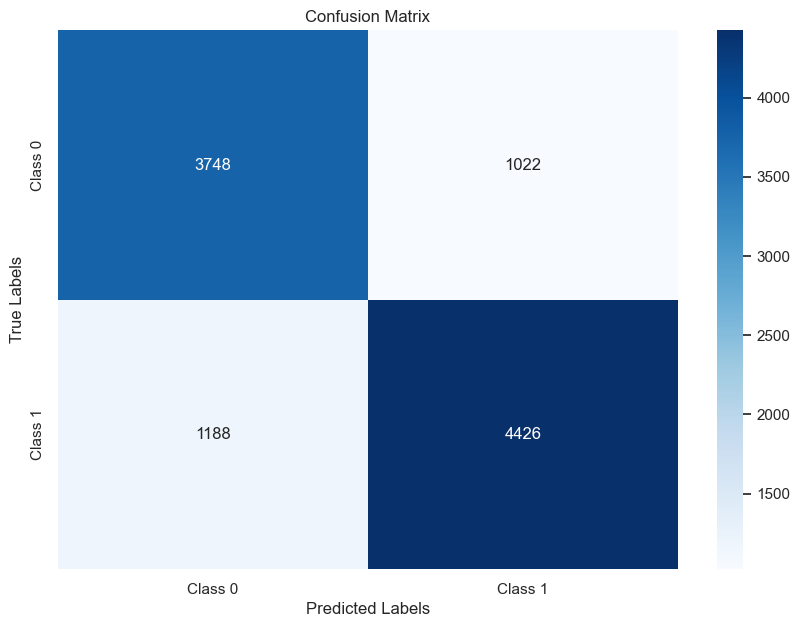

In [472]:
# Step 2: Make Predictions
y_pred_test_cm = best_rf.predict(X_test)

# Step 3: Compute the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test_cm)

# Step 4: Print the Confusion Matrix
print("Confusion Matrix:")
print(cm)

# Plot the Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



interpetaion in the PDF

Feature ranking (descending order):
1. feature stack_experience (0.618779)
2. feature D (0.264132)
3. feature education (0.019162)
4. feature A (0.018102)
5. feature prev_salary (0.018004)
6. feature is_dev (0.017166)
7. feature years_of_experience (0.013928)
8. feature country (0.010804)
9. feature C (0.006580)
10. feature sex (0.003509)
11. feature mental_issues (0.002740)
12. feature age_group (0.002714)
13. feature worked_in_the_past (0.002407)
14. feature disability (0.001974)


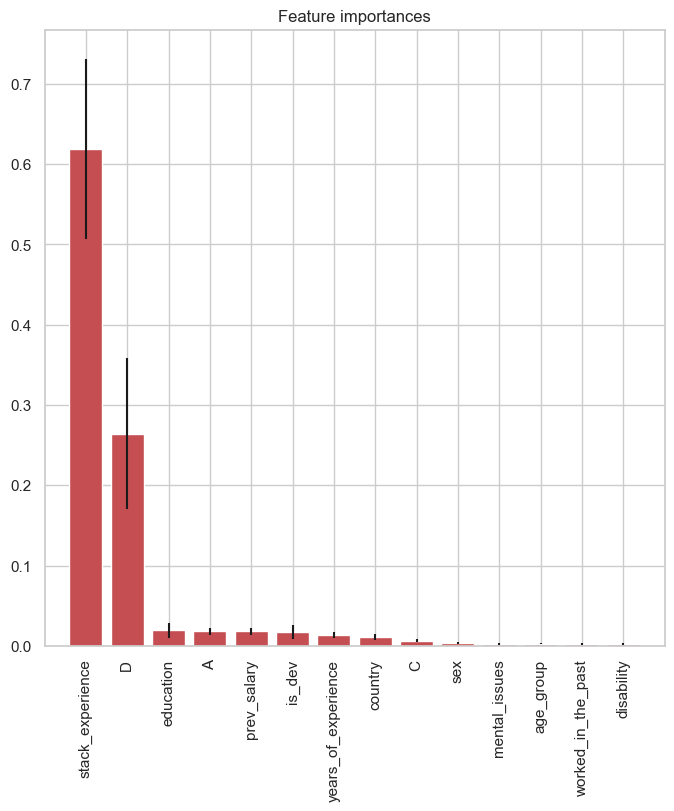

In [473]:
feature_names = data.columns[:-1].tolist()  # All columns except the last one
importances = best_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Sort the feature names based on the importance indices
sorted_feature_names = [feature_names[i] for i in indices]

# Print the feature ranking in descending order of importance
print("Feature ranking (descending order):")
for i, idx in enumerate(indices):
    print(f"{i + 1}. feature {sorted_feature_names[i]} ({importances[idx]:.6f})")

# Plot the feature importances of the forest
plt.figure(figsize=(8, 8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), sorted_feature_names, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


interpetation in the PDF

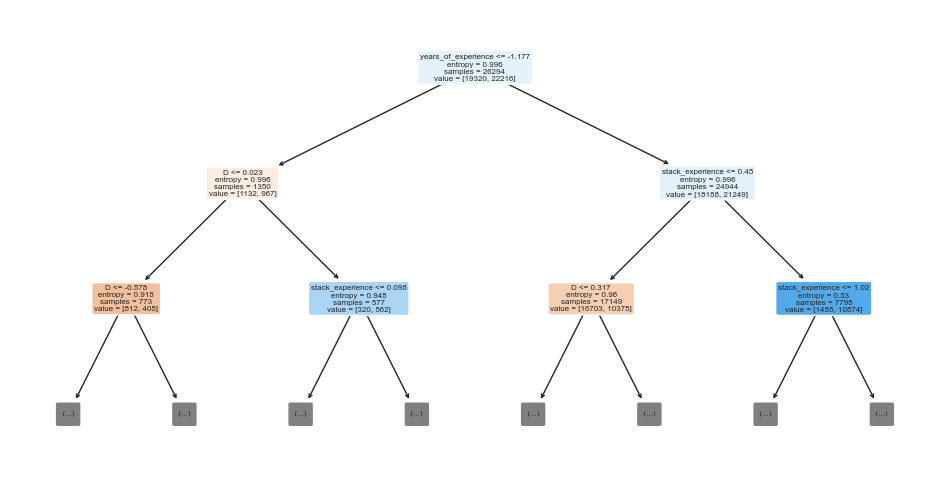

In [474]:
# Select the first tree from the random forest
tree = best_rf.estimators_[11]
# Plot the tree
plt.figure(figsize=(12, 6))
plot_tree(tree, max_depth=2, filled=True, feature_names=feature_names, rounded=True)
plt.show()

above there is a visualization of our randonmg forest, its an example of 1 estimatior, in this example we can see number of samples in each split, the entropy (represnts putrity of the node) so we can see for example the first split regarding to stack experience <= 0.35 contains almost 26k samples, its very pure (its the first split) and later we can see other criterias for splitting.

Multi Layer Perceptron - with pca

In [475]:
# param_grid_mlp = {
#     'hidden_layer_sizes': [(50,), (100,), (50, 50)],
#     'activation': ['relu', 'tanh'],
#     'solver': ['adam'],
#     'alpha': [0.0001, 0.001],
#     'batch_size': [32, 64],
#     'learning_rate': ['adaptive']
# }


# # Instantiate the MLPClassifier
# mlp = MLPClassifier(max_iter=500)

# # Instantiate and fit GridSearchCV
# optimizer_mlp = GridSearchCV(mlp, param_grid_mlp, scoring='roc_auc', cv=2, n_jobs=-1, return_train_score=True)
# optimizer_mlp.fit(X_train, y_train)

# # Print the best parameters found by the grid search
# print("Best Parameters for MLP:", optimizer_mlp.best_params_)

# # Print the best ROC AUC score
# print("Best ROC AUC score from GridSearchCV:", optimizer_mlp.best_score_)

In [476]:
param_grid_mlp = {
    'hidden_layer_sizes': (50,),
    'activation': 'relu',
    'solver': 'adam',
    'alpha': 0.001,
    'batch_size': 64,
    'learning_rate': 'adaptive'
}
#best model with the best parameters
best_mlp_pca = MLPClassifier(**param_grid_mlp, max_iter=500)

In [477]:
# Initialize lists to store ROC curve data and AUC scores
fpr_list_mlp_pca = []
tpr_list_mlp_pca = []
auc_list_mlp_pca = []
auc_train_list_mlp_pca = []
auc_val_list_mlp_pca = []

kf_mlp_pca = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Perform K-Fold Cross-Validation and compute ROC curves for each fold
for train_index, test_index in kf.split(X_train_pca, y_train):
    X_mlp_train_pca, X_mlp_test_pca = X_train_pca[train_index], X_train_pca[test_index]
    y_mlp_train_pca, y_mlp_test_pca = y_train[train_index], y_train[test_index]

    # Train the model
    best_mlp_pca.fit(X_mlp_train_pca, y_mlp_train_pca)

    # Predict probabilities for the training set
    y_mlp_proba_train_pca = best_mlp_pca.predict_proba(X_mlp_train_pca)[:, 1]
    # Predict probabilities for the validation set
    y_mlp_proba_val_pca = best_mlp_pca.predict_proba(X_mlp_test_pca)[:, 1]

    # Compute ROC curve and AUC for the validation set
    fpr_pca, tpr_pca, _ = roc_curve(y_mlp_test_pca, y_mlp_proba_val_pca)
    roc_auc_pca = auc(fpr, tpr)

    # Compute AUC for training set
    auc_train_pca = roc_auc_score(y_mlp_train_pca, y_mlp_proba_train_pca)
    # Compute AUC for validation set
    auc_val_pca = roc_auc_score(y_mlp_test_pca, y_mlp_proba_val_pca)

    # Store results
    fpr_list_mlp_pca.append(fpr_pca)
    tpr_list_mlp_pca.append(tpr_pca)
    auc_list_mlp_pca.append(roc_auc_pca)
    auc_train_list_mlp_pca.append(auc_train_pca)
    auc_val_list_mlp_pca.append(auc_val_pca)


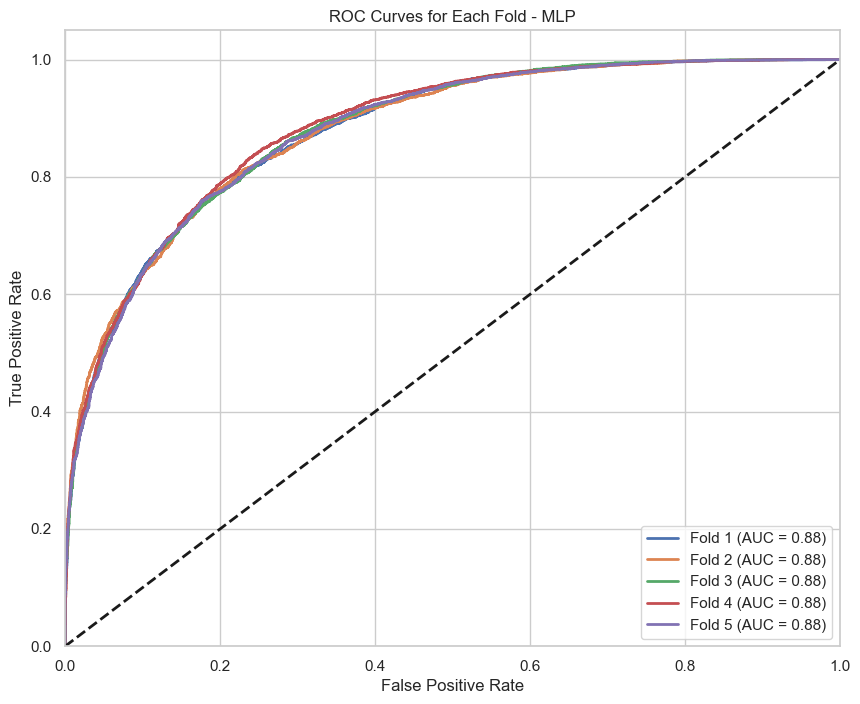

In [478]:
# Plot ROC curves for each fold
plt.figure(figsize=(10, 8))
for i in range(len(fpr_list_mlp_pca)):
    plt.plot(fpr_list_mlp_pca[i], tpr_list_mlp_pca[i], lw=2, label=f'Fold {i+1} (AUC = {auc_list_mlp_pca[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Fold - MLP')
plt.legend(loc='lower right')
plt.show()


we see stabilized predictions over the validation sets.

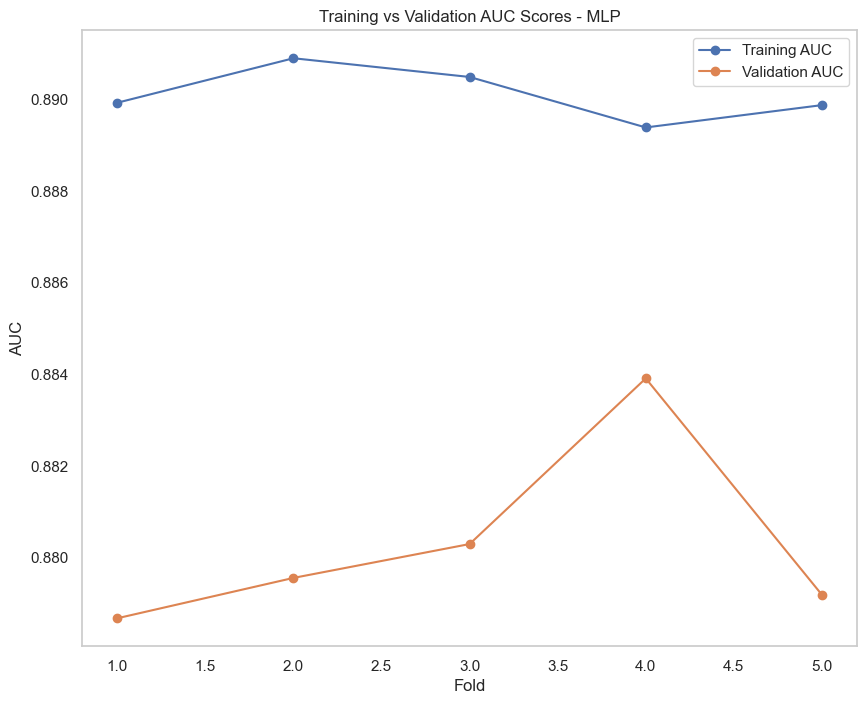

In [479]:
# Compare Training and Validation AUC Scores
plt.figure(figsize=(10, 8))
plt.plot(range(1, kf_mlp_pca.get_n_splits() + 1), auc_train_list_mlp_pca, marker='o', label='Training AUC')
plt.plot(range(1, kf_mlp_pca.get_n_splits() + 1), auc_val_list_mlp_pca, marker='o', label='Validation AUC')
plt.xlabel('Fold')
plt.ylabel('AUC')
plt.title('Training vs Validation AUC Scores - MLP')
plt.legend()
plt.grid()
plt.show()

we see that sometimes we have realtivly big difference and sometimes there is not, which means the model is not so stable altough it has sliglty better results then the Rf - still we decided to choose the RF because of stabilty on the validation set.

In [480]:

# Train the best model on the entire training set
best_mlp_pca.fit(X_train_pca, y_train)

# Make predictions on the training and test data
y_proba_train_mlp_pca = best_mlp_pca.predict_proba(X_train_pca)[:, 1]
y_proba_test_mlp_pca = best_mlp_pca.predict_proba(X_test_pca)[:, 1]

# Compute AUC for training and test data
auc_train_mlp_pca = roc_auc_score(y_train, y_proba_train_mlp_pca)
auc_test_mlp_pca = roc_auc_score(y_test, y_proba_test_mlp_pca)

print(f"ROC AUC on Training Set: {auc_train_mlp_pca:.4f}")
print(f"ROC AUC on Test Set: {auc_test_mlp_pca:.4f}")


ROC AUC on Training Set: 0.8888
ROC AUC on Test Set: 0.8804


MLP - without PCA

In [481]:
#best model with the best parameters
best_mlp = MLPClassifier(**param_grid_mlp, max_iter=500)
# Initialize lists to store ROC curve data and AUC scores
fpr_list_mlp = []
tpr_list_mlp = []
auc_list_mlp = []
auc_train_list_mlp = []
auc_val_list_mlp = []

kf_mlp = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Perform K-Fold Cross-Validation and compute ROC curves for each fold
for train_index, test_index in kf.split(X_train, y_train):
    X_mlp_train, X_mlp_test = X_train[train_index], X_train[test_index]
    y_mlp_train, y_mlp_test = y_train[train_index], y_train[test_index]

    # Train the model
    best_mlp.fit(X_mlp_train, y_mlp_train)

    # Predict probabilities for the training set
    y_mlp_proba_train = best_mlp.predict_proba(X_mlp_train)[:, 1]
    # Predict probabilities for the validation set
    y_mlp_proba_val = best_mlp.predict_proba(X_mlp_test)[:, 1]

    # Compute ROC curve and AUC for the validation set
    fpr_mlp, tpr_mlp, _ = roc_curve(y_mlp_test, y_mlp_proba_val)
    roc_auc_mlp = auc(fpr, tpr)

    # Compute AUC for training set
    auc_train_mlp = roc_auc_score(y_mlp_train, y_mlp_proba_train)
    # Compute AUC for validation set
    auc_val_mlp = roc_auc_score(y_mlp_test, y_mlp_proba_val)

    # Store results
    fpr_list_mlp.append(fpr_mlp)
    tpr_list_mlp.append(tpr_mlp)
    auc_list_mlp.append(roc_auc)
    auc_train_list_mlp.append(auc_train_mlp)
    auc_val_list_mlp.append(auc_val_mlp)


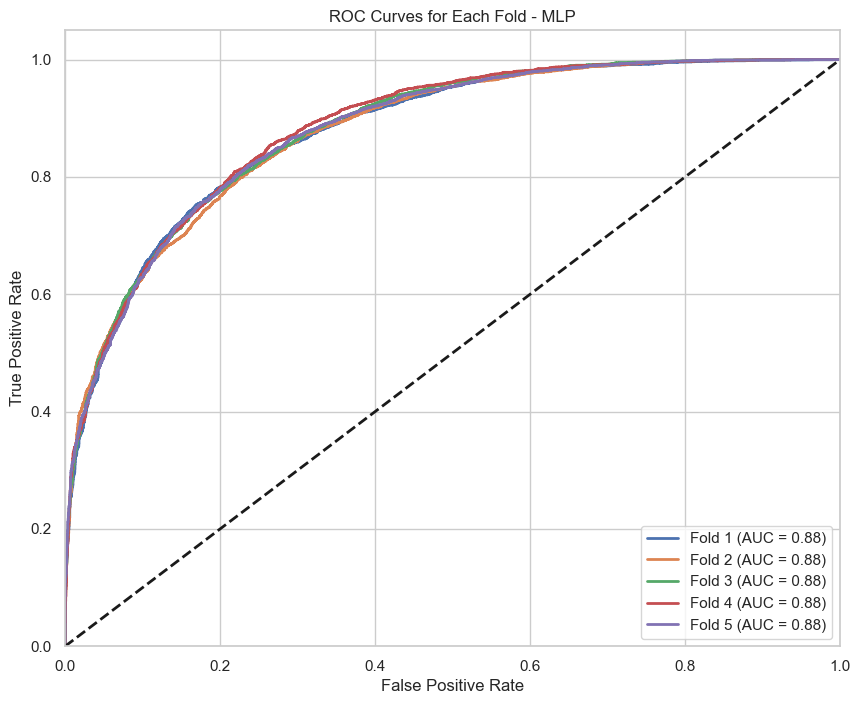

In [482]:
# Plot ROC curves for each fold
plt.figure(figsize=(10, 8))
for i in range(len(fpr_list_mlp)):
    plt.plot(fpr_list_mlp[i], tpr_list_mlp[i], lw=2, label=f'Fold {i+1} (AUC = {auc_list_mlp[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Fold - MLP')
plt.legend(loc='lower right')
plt.show()


we see stabilized predictions over the validation sets.

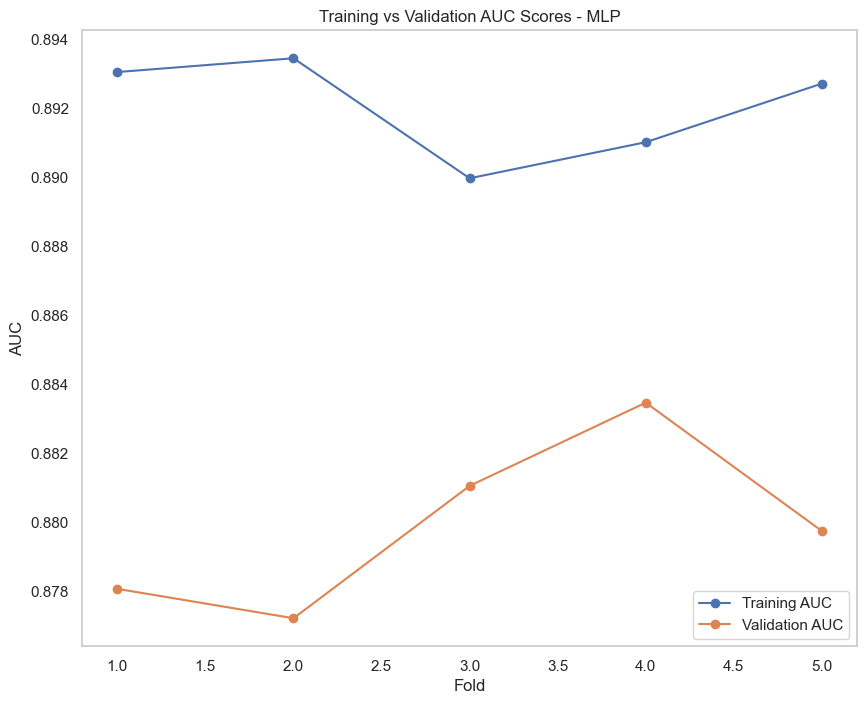

In [483]:
# Compare Training and Validation AUC Scores
plt.figure(figsize=(10, 8))
plt.plot(range(1, kf_mlp.get_n_splits() + 1), auc_train_list_mlp, marker='o', label='Training AUC')
plt.plot(range(1, kf_mlp.get_n_splits() + 1), auc_val_list_mlp, marker='o', label='Validation AUC')
plt.xlabel('Fold')
plt.ylabel('AUC')
plt.title('Training vs Validation AUC Scores - MLP')
plt.legend()
plt.grid()
plt.show()

we see that the validation score and the train score are almost the same which indicates we are balanced and not overfitted.

In [484]:

# Train the best model on the entire training set
best_mlp.fit(X_train, y_train)

# Make predictions on the training and test data
y_proba_train_mlp = best_mlp.predict_proba(X_train)[:, 1]
y_proba_test_mlp = best_mlp.predict_proba(X_test)[:, 1]

# Compute AUC for training and test data
auc_train_mlp = roc_auc_score(y_train, y_proba_train_mlp)
auc_test_mlp = roc_auc_score(y_test, y_proba_test_mlp)

print(f"ROC AUC on Training Set: {auc_train_mlp:.4f}")
print(f"ROC AUC on Test Set: {auc_test_mlp:.4f}")


ROC AUC on Training Set: 0.8919
ROC AUC on Test Set: 0.8781


In [ ]:
from sklearn.inspection import permutation_importance
result = permutation_importance(best_mlp, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1)

# Get feature importances and their standard deviations
importances = result.importances_mean
std = result.importances_std
normalized_importances = importances / np.sum(importances)
# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for i in range(X_train.shape[1]):
    print(f"{i + 1}. feature {feature_names[indices[i]]} ({normalized_importances[indices[i]]:.6f})")



Feature ranking:
1. feature stack_experience (0.617001)
2. feature D (0.231887)
3. feature prev_salary (0.021332)
4. feature years_of_experience (0.018606)
5. feature education (0.017897)
6. feature country (0.014287)
7. feature age_group (0.014020)
8. feature C (0.012376)
9. feature is_dev (0.012193)
10. feature A (0.011449)
11. feature mental_issues (0.010761)
12. feature worked_in_the_past (0.010016)
13. feature sex (0.004832)
14. feature disability (0.003343)


# Part 5 : Making a Prediction

The chosen modle is Random Forest

In [486]:
# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import StandardScaler
# from scipy import stats
# %matplotlib inline
# from sklearn.model_selection import KFold
# from sklearn.decomposition import PCA
# from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve
# from sklearn.pipeline import Pipeline, FeatureUnion
# from sklearn.preprocessing import FunctionTransformer
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

In [854]:
# data = pd.read_csv('train.csv') 
# cont_data = pd.read_csv('countryContinent.csv', encoding='ISO-8859-1')
test_data = pd.read_csv("test.csv")


In [855]:
map_country_to_continent(test_data)
test_data = apply_target_encoding(test_data, ['education', 'C', 'country'], mappings, numeric_means)
test_data = apply_stack_experience_encoding(test_data, 'stack_experience', stack_exp_mappings)
test_ID_col = test_data['ID']



In [851]:
precomputed_medians

{'B': 6.0, 'prev_salary': 57072.0, 'years_of_experience': 11.0}

In [856]:
test_data = apply_process_disability(test_data, disability_mean)
test_data = apply_process_is_dev(test_data, is_dev_mean)
test_data = apply_process_sex(test_data, sex_mean)
test_data = apply_process_mental_issues(test_data, mental_issues_mean)
test_data = apply_worked_in_the_past(test_data, worked_in_the_past_mean)
test_data = apply_fill_nulls_with_mean(test_data, precomputed_means, ['A', 'D'])
test_data = apply_fill_nulls_with_median(test_data, precomputed_medians, ['prev_salary', 'years_of_experience'])
test_data = apply_process_age_group(test_data, age_group_mean)
test_data = apply_scale_numeric_columns(test_data, fitted_scaler, numeric_cols_train )

In [857]:
test_data = drop_column(test_data, ['ID', 'B'])

In [858]:
best_rf_params = {
    'n_estimators': 150,
    'max_depth': 10,
    'min_samples_split': 20,
    'min_samples_leaf': 5,
    'bootstrap': True,
    'criterion': 'entropy'
}
final_rf = RandomForestClassifier(**best_rf_params, n_jobs=-1)

In [859]:
final_rf.fit(X, Y)


RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5,
                       min_samples_split=20, n_estimators=150, n_jobs=-1)

In [860]:
test_data.head(5)

,worked_in_the_past,age_group,disability,is_dev,education,sex,mental_issues,years_of_experience,A,C,D,country,prev_salary,stack_experience
0,-2.835705,-0.719006,0.174505,0.298456,3.684234e-01,0.267234,-0.551331,-1.000801,0.984680,0.702800,-0.934550,4.172922e-01,-0.099634,-0.035948
1,0.364217,1.459067,0.174505,-3.481156,8.166399e-01,0.267234,-0.551331,-1.000801,-1.060286,0.702800,-0.487415,-3.786744e-15,-0.803632,-0.234259
2,0.364217,-0.000242,0.174505,0.298456,1.908939e-15,0.267234,-0.551331,0.893168,0.689644,0.000000,0.765080,4.535425e-01,-0.162602,-1.140576
3,0.364217,1.459067,-0.002398,0.298456,3.684234e-01,0.267234,-0.551331,0.893168,-1.254936,-0.910515,1.660904,-3.786744e-15,1.193416,3.011431
4,-2.835705,1.459067,0.174505,0.298456,8.166399e-01,0.267234,-0.551331,3.418461,-1.528320,0.702800,0.169225,-5.555572e-01,-0.162602,0.248572


In [138]:
# X.shape

In [139]:
# test_data.head()

we had several problems related to number of features with the test data and the trained model so we did some chekcings in the above cells.

In [861]:
test_features = np.array(test_data)

In [862]:
y_proba = final_rf.predict_proba(test_features)
probabilities = y_proba[:, 1]


In [863]:
final_results = pd.DataFrame({
    'ID': test_ID_col,
    'Probability': probabilities
})

# Save the DataFrame to a CSV file
final_results.to_csv('results_group_7.csv', index=False)
